In [1]:
import torch
import data
import tqdm
import models
import numpy as np
from torchvision.transforms import v2
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
EPOCHS = 500
BATCH_SIZE = 5
LR = 1e-6

In [3]:
dataset = data.LensingDataset('../dataset_2/','sparse')
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [4]:
generator = models.Resnet_SISR(residual_depth=10, 
                                in_channels=1, 
                                maginfication=2, 
                                num_magnifications=1, 
                                latent_channel_count=64).to(device)
generator.load_state_dict(torch.load('../trained_weights/ResnetSISR_sparse.pt'))
discriminator = models.Discriminator(residual_depth=7).to(device)
feature_mapper = models.Resnet_simple().to(device)
classifier_weights = torch.load('../trained_weights/resnet_simple.pt')
truncated_weights = {}
for key,value in classifier_weights.items():
    if key.startswith('conv1') or key.startswith('conv2') | key.startswith('bn1') | key.startswith('bn2'):
        truncated_weights[key] = value
feature_mapper.load_state_dict(truncated_weights)
for m in feature_mapper.modules():
    m.requires_grad_(False)

In [5]:
feature_loss = torch.nn.MSELoss()
adversarial_loss = torch.nn.CrossEntropyLoss()
gen_opt = torch.optim.Adam(params=filter(lambda p: p.requires_grad, generator.parameters()),lr=LR)
disc_opt = torch.optim.Adam(params=filter(lambda p: p.requires_grad, discriminator.parameters()),lr=LR)

In [6]:
train_history = {'f_loss':[], 'a_loss':[], 'd_loss':[]}
val_history = {'f_loss':[], 'a_loss':[], 'd_loss':[]}
beta = 1e-3
best_val_loss = np.inf
best_weights = None
for epoch in range(EPOCHS):
    f_loss = []
    a_loss = []
    d_loss = []
    generator.train()
    discriminator.train()
    for i,(x,y) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x, y) = (x.float().to(device), y.float().to(device))
        x_SR = generator(x)
        x_feature = feature_mapper(x_SR)
        y_feature = feature_mapper(y).detach() 
        x_discrim = discriminator(x_SR)
        features_lost = feature_loss(x_feature,y_feature)
        ad_lost = adversarial_loss(x_discrim, torch.ones_like(x_discrim))
        perceptual_loss = features_lost + beta*ad_lost
        gen_opt.zero_grad()
        perceptual_loss.backward()
        gen_opt.step()
        f_loss.append(float(features_lost))
        a_loss.append(float(ad_lost))

        y_discrim = discriminator(y)
        x_discrim = discriminator(x_SR.detach())

        ad_lost = adversarial_loss(x_discrim,torch.zeros_like(x_discrim))+adversarial_loss(y_discrim,torch.zeros_like(y_discrim))
        disc_opt.zero_grad()
        ad_lost.backward()
        disc_opt.step()
        d_loss.append(float(ad_lost))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: f_loss={np.mean(f_loss)}")
    # train_history['d_loss'].append(np.mean(d_loss))
    # train_history['a_loss'].append(np.mean(a_loss))
    train_history['f_loss'].append(np.mean(f_loss))
    generator.eval()
    discriminator.eval()
    f_loss = []
    a_loss = []
    d_loss = []
    for i,(x,y) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x, y) = (x.float().to(device), y.float().to(device))
        x_SR = generator(x)
        x_feature = feature_mapper(x_SR)
        y_feature = feature_mapper(y).detach() 
        x_discrim = discriminator(x_SR)
        features_lost = feature_loss(x_feature,y_feature)
        ad_lost = adversarial_loss(x_discrim, torch.ones_like(x_discrim))
        perceptual_loss = features_lost + beta*ad_lost
        f_loss.append(float(features_lost))
        a_loss.append(float(ad_lost))

        y_discrim = discriminator(y)
        x_discrim = discriminator(x_SR.detach())

        ad_lost = adversarial_loss(x_discrim,torch.zeros_like(x_discrim))+adversarial_loss(y_discrim,torch.zeros_like(y_discrim))
        d_loss.append(float(ad_lost))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: f_loss={np.mean(f_loss)}")
    # val_history['d_loss'].append(np.mean(d_loss))
    # val_history['a_loss'].append(np.mean(a_loss))
    val_history['f_loss'].append(np.mean(f_loss))

Training epoch 1: 100%|██████████| 54/54 [00:09<00:00,  5.77it/s]


Training at epoch 1/500: f_loss=0.15793611419697604


Training epoch 1: 100%|██████████| 54/54 [00:03<00:00, 17.13it/s]


Validation at epoch 1/500: f_loss=0.15310569845691877


Training epoch 2: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 2/500: f_loss=0.153259573849263


Training epoch 2: 100%|██████████| 54/54 [00:02<00:00, 18.15it/s]


Validation at epoch 2/500: f_loss=0.1506998722475988


Training epoch 3: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 3/500: f_loss=0.15349342487752438


Training epoch 3: 100%|██████████| 54/54 [00:03<00:00, 17.92it/s]


Validation at epoch 3/500: f_loss=0.14975241792422753


Training epoch 4: 100%|██████████| 54/54 [00:06<00:00,  8.52it/s]


Training at epoch 4/500: f_loss=0.14992105188193144


Training epoch 4: 100%|██████████| 54/54 [00:02<00:00, 18.01it/s]


Validation at epoch 4/500: f_loss=0.15143308540185293


Training epoch 5: 100%|██████████| 54/54 [00:06<00:00,  8.56it/s]


Training at epoch 5/500: f_loss=0.14765707541395118


Training epoch 5: 100%|██████████| 54/54 [00:02<00:00, 18.11it/s]


Validation at epoch 5/500: f_loss=0.14695116629203162


Training epoch 6: 100%|██████████| 54/54 [00:06<00:00,  8.53it/s]


Training at epoch 6/500: f_loss=0.14829372545635258


Training epoch 6: 100%|██████████| 54/54 [00:02<00:00, 18.11it/s]


Validation at epoch 6/500: f_loss=0.1440044244820321


Training epoch 7: 100%|██████████| 54/54 [00:06<00:00,  8.53it/s]


Training at epoch 7/500: f_loss=0.1464699519177278


Training epoch 7: 100%|██████████| 54/54 [00:03<00:00, 17.21it/s]


Validation at epoch 7/500: f_loss=0.1499261858838576


Training epoch 8: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 8/500: f_loss=0.1481707172675265


Training epoch 8: 100%|██████████| 54/54 [00:03<00:00, 17.57it/s]


Validation at epoch 8/500: f_loss=0.14377758734756046


Training epoch 9: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 9/500: f_loss=0.1441994565366595


Training epoch 9: 100%|██████████| 54/54 [00:03<00:00, 17.69it/s]


Validation at epoch 9/500: f_loss=0.1456858159767257


Training epoch 10: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 10/500: f_loss=0.14418022520840168


Training epoch 10: 100%|██████████| 54/54 [00:03<00:00, 17.41it/s]


Validation at epoch 10/500: f_loss=0.14431511252014725


Training epoch 11: 100%|██████████| 54/54 [00:06<00:00,  8.30it/s]


Training at epoch 11/500: f_loss=0.14883532375097275


Training epoch 11: 100%|██████████| 54/54 [00:03<00:00, 17.41it/s]


Validation at epoch 11/500: f_loss=0.1462923663633841


Training epoch 12: 100%|██████████| 54/54 [00:06<00:00,  8.28it/s]


Training at epoch 12/500: f_loss=0.1468896324297896


Training epoch 12: 100%|██████████| 54/54 [00:03<00:00, 17.27it/s]


Validation at epoch 12/500: f_loss=0.14368072110745642


Training epoch 13: 100%|██████████| 54/54 [00:06<00:00,  8.25it/s]


Training at epoch 13/500: f_loss=0.14503093325981387


Training epoch 13: 100%|██████████| 54/54 [00:03<00:00, 17.47it/s]


Validation at epoch 13/500: f_loss=0.14418890672149481


Training epoch 14: 100%|██████████| 54/54 [00:06<00:00,  8.28it/s]


Training at epoch 14/500: f_loss=0.14051890945820897


Training epoch 14: 100%|██████████| 54/54 [00:03<00:00, 17.28it/s]


Validation at epoch 14/500: f_loss=0.14020892405123622


Training epoch 15: 100%|██████████| 54/54 [00:06<00:00,  8.31it/s]


Training at epoch 15/500: f_loss=0.14320571713701444


Training epoch 15: 100%|██████████| 54/54 [00:03<00:00, 17.61it/s]


Validation at epoch 15/500: f_loss=0.14483207133081225


Training epoch 16: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 16/500: f_loss=0.1437006581712652


Training epoch 16: 100%|██████████| 54/54 [00:03<00:00, 17.08it/s]


Validation at epoch 16/500: f_loss=0.14296917555232844


Training epoch 17: 100%|██████████| 54/54 [00:06<00:00,  8.31it/s]


Training at epoch 17/500: f_loss=0.14528268134152447


Training epoch 17: 100%|██████████| 54/54 [00:03<00:00, 17.30it/s]


Validation at epoch 17/500: f_loss=0.1433716539155554


Training epoch 18: 100%|██████████| 54/54 [00:06<00:00,  8.29it/s]


Training at epoch 18/500: f_loss=0.1462596999136386


Training epoch 18: 100%|██████████| 54/54 [00:03<00:00, 17.12it/s]


Validation at epoch 18/500: f_loss=0.13980004025830162


Training epoch 19: 100%|██████████| 54/54 [00:06<00:00,  8.19it/s]


Training at epoch 19/500: f_loss=0.1372269476177516


Training epoch 19: 100%|██████████| 54/54 [00:03<00:00, 17.10it/s]


Validation at epoch 19/500: f_loss=0.14114922581723444


Training epoch 20: 100%|██████████| 54/54 [00:06<00:00,  8.27it/s]


Training at epoch 20/500: f_loss=0.1390225670679852


Training epoch 20: 100%|██████████| 54/54 [00:03<00:00, 17.54it/s]


Validation at epoch 20/500: f_loss=0.1362555494049081


Training epoch 21: 100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


Training at epoch 21/500: f_loss=0.14030200180908045


Training epoch 21: 100%|██████████| 54/54 [00:03<00:00, 17.57it/s]


Validation at epoch 21/500: f_loss=0.1419042579277798


Training epoch 22: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 22/500: f_loss=0.1410394493766405


Training epoch 22: 100%|██████████| 54/54 [00:03<00:00, 17.28it/s]


Validation at epoch 22/500: f_loss=0.13987026812025793


Training epoch 23: 100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


Training at epoch 23/500: f_loss=0.13987700206538042


Training epoch 23: 100%|██████████| 54/54 [00:03<00:00, 17.49it/s]


Validation at epoch 23/500: f_loss=0.13968113140651472


Training epoch 24: 100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


Training at epoch 24/500: f_loss=0.14489635328451791


Training epoch 24: 100%|██████████| 54/54 [00:03<00:00, 17.51it/s]


Validation at epoch 24/500: f_loss=0.14042708712319532


Training epoch 25: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 25/500: f_loss=0.13974883214191156


Training epoch 25: 100%|██████████| 54/54 [00:03<00:00, 17.46it/s]


Validation at epoch 25/500: f_loss=0.13853525377258105


Training epoch 26: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 26/500: f_loss=0.14143881374211223


Training epoch 26: 100%|██████████| 54/54 [00:03<00:00, 17.52it/s]


Validation at epoch 26/500: f_loss=0.13944474959539044


Training epoch 27: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 27/500: f_loss=0.13740740854431083


Training epoch 27: 100%|██████████| 54/54 [00:03<00:00, 17.17it/s]


Validation at epoch 27/500: f_loss=0.14268042243741177


Training epoch 28: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 28/500: f_loss=0.14150682312470894


Training epoch 28: 100%|██████████| 54/54 [00:03<00:00, 17.18it/s]


Validation at epoch 28/500: f_loss=0.14363867755013485


Training epoch 29: 100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


Training at epoch 29/500: f_loss=0.13758427635939033


Training epoch 29: 100%|██████████| 54/54 [00:03<00:00, 17.42it/s]


Validation at epoch 29/500: f_loss=0.14154020400234946


Training epoch 30: 100%|██████████| 54/54 [00:06<00:00,  8.30it/s]


Training at epoch 30/500: f_loss=0.13805165679918396


Training epoch 30: 100%|██████████| 54/54 [00:03<00:00, 16.98it/s]


Validation at epoch 30/500: f_loss=0.13783186929369415


Training epoch 31: 100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


Training at epoch 31/500: f_loss=0.1414663141110429


Training epoch 31: 100%|██████████| 54/54 [00:03<00:00, 17.08it/s]


Validation at epoch 31/500: f_loss=0.13713649736234435


Training epoch 32: 100%|██████████| 54/54 [00:06<00:00,  8.31it/s]


Training at epoch 32/500: f_loss=0.13842055525768687


Training epoch 32: 100%|██████████| 54/54 [00:03<00:00, 17.47it/s]


Validation at epoch 32/500: f_loss=0.13992023426625463


Training epoch 33: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 33/500: f_loss=0.14065764057967398


Training epoch 33: 100%|██████████| 54/54 [00:03<00:00, 17.72it/s]


Validation at epoch 33/500: f_loss=0.13922344355119598


Training epoch 34: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 34/500: f_loss=0.1398153187086185


Training epoch 34: 100%|██████████| 54/54 [00:03<00:00, 17.47it/s]


Validation at epoch 34/500: f_loss=0.13788160619636378


Training epoch 35: 100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


Training at epoch 35/500: f_loss=0.1390896512678376


Training epoch 35: 100%|██████████| 54/54 [00:03<00:00, 17.27it/s]


Validation at epoch 35/500: f_loss=0.13938565510842535


Training epoch 36: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 36/500: f_loss=0.13714621981812847


Training epoch 36: 100%|██████████| 54/54 [00:03<00:00, 17.41it/s]


Validation at epoch 36/500: f_loss=0.14019867819216517


Training epoch 37: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 37/500: f_loss=0.1397130135446787


Training epoch 37: 100%|██████████| 54/54 [00:03<00:00, 17.31it/s]


Validation at epoch 37/500: f_loss=0.13633842000530827


Training epoch 38: 100%|██████████| 54/54 [00:06<00:00,  8.25it/s]


Training at epoch 38/500: f_loss=0.13809397016410474


Training epoch 38: 100%|██████████| 54/54 [00:03<00:00, 17.38it/s]


Validation at epoch 38/500: f_loss=0.13729117631360335


Training epoch 39: 100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Training at epoch 39/500: f_loss=0.13831046658257642


Training epoch 39: 100%|██████████| 54/54 [00:03<00:00, 17.38it/s]


Validation at epoch 39/500: f_loss=0.13841973755646636


Training epoch 40: 100%|██████████| 54/54 [00:06<00:00,  8.21it/s]


Training at epoch 40/500: f_loss=0.13895448304160876


Training epoch 40: 100%|██████████| 54/54 [00:03<00:00, 17.39it/s]


Validation at epoch 40/500: f_loss=0.13500606351428562


Training epoch 41: 100%|██████████| 54/54 [00:06<00:00,  8.29it/s]


Training at epoch 41/500: f_loss=0.13742327214115196


Training epoch 41: 100%|██████████| 54/54 [00:03<00:00, 17.43it/s]


Validation at epoch 41/500: f_loss=0.1397366330579475


Training epoch 42: 100%|██████████| 54/54 [00:06<00:00,  8.30it/s]


Training at epoch 42/500: f_loss=0.13539690896868706


Training epoch 42: 100%|██████████| 54/54 [00:03<00:00, 17.69it/s]


Validation at epoch 42/500: f_loss=0.13937005704199826


Training epoch 43: 100%|██████████| 54/54 [00:06<00:00,  8.30it/s]


Training at epoch 43/500: f_loss=0.135537168631951


Training epoch 43: 100%|██████████| 54/54 [00:03<00:00, 17.35it/s]


Validation at epoch 43/500: f_loss=0.13960237925251326


Training epoch 44: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 44/500: f_loss=0.13589495958553421


Training epoch 44: 100%|██████████| 54/54 [00:03<00:00, 17.62it/s]


Validation at epoch 44/500: f_loss=0.13602296883861223


Training epoch 45: 100%|██████████| 54/54 [00:06<00:00,  8.27it/s]


Training at epoch 45/500: f_loss=0.13377189546547555


Training epoch 45: 100%|██████████| 54/54 [00:03<00:00, 17.25it/s]


Validation at epoch 45/500: f_loss=0.13235408378144106


Training epoch 46: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 46/500: f_loss=0.1355892854432265


Training epoch 46: 100%|██████████| 54/54 [00:03<00:00, 17.26it/s]


Validation at epoch 46/500: f_loss=0.13692672274730824


Training epoch 47: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 47/500: f_loss=0.13502366813244643


Training epoch 47: 100%|██████████| 54/54 [00:03<00:00, 17.54it/s]


Validation at epoch 47/500: f_loss=0.13641387824383047


Training epoch 48: 100%|██████████| 54/54 [00:06<00:00,  8.29it/s]


Training at epoch 48/500: f_loss=0.13719793478095973


Training epoch 48: 100%|██████████| 54/54 [00:03<00:00, 16.81it/s]


Validation at epoch 48/500: f_loss=0.13875332053888728


Training epoch 49: 100%|██████████| 54/54 [00:06<00:00,  8.27it/s]


Training at epoch 49/500: f_loss=0.1352061569966652


Training epoch 49: 100%|██████████| 54/54 [00:03<00:00, 17.37it/s]


Validation at epoch 49/500: f_loss=0.13870131997046647


Training epoch 50: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 50/500: f_loss=0.13437785884296452


Training epoch 50: 100%|██████████| 54/54 [00:03<00:00, 17.68it/s]


Validation at epoch 50/500: f_loss=0.13344015864034495


Training epoch 51: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 51/500: f_loss=0.13835401039708545


Training epoch 51: 100%|██████████| 54/54 [00:03<00:00, 17.49it/s]


Validation at epoch 51/500: f_loss=0.1346968389633629


Training epoch 52: 100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Training at epoch 52/500: f_loss=0.13589005834526485


Training epoch 52: 100%|██████████| 54/54 [00:03<00:00, 16.96it/s]


Validation at epoch 52/500: f_loss=0.13629100871858774


Training epoch 53: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 53/500: f_loss=0.13593427326392243


Training epoch 53: 100%|██████████| 54/54 [00:03<00:00, 17.43it/s]


Validation at epoch 53/500: f_loss=0.13527408863107362


Training epoch 54: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 54/500: f_loss=0.13514617030267362


Training epoch 54: 100%|██████████| 54/54 [00:03<00:00, 17.36it/s]


Validation at epoch 54/500: f_loss=0.13108539774462027


Training epoch 55: 100%|██████████| 54/54 [00:06<00:00,  8.30it/s]


Training at epoch 55/500: f_loss=0.13514272903126698


Training epoch 55: 100%|██████████| 54/54 [00:03<00:00, 16.93it/s]


Validation at epoch 55/500: f_loss=0.13594117795151692


Training epoch 56: 100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


Training at epoch 56/500: f_loss=0.13539242951406372


Training epoch 56: 100%|██████████| 54/54 [00:03<00:00, 16.95it/s]


Validation at epoch 56/500: f_loss=0.1350522902276781


Training epoch 57: 100%|██████████| 54/54 [00:06<00:00,  8.27it/s]


Training at epoch 57/500: f_loss=0.1362813283447866


Training epoch 57: 100%|██████████| 54/54 [00:03<00:00, 17.77it/s]


Validation at epoch 57/500: f_loss=0.13467667955491278


Training epoch 58: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 58/500: f_loss=0.13504537305346243


Training epoch 58: 100%|██████████| 54/54 [00:03<00:00, 17.53it/s]


Validation at epoch 58/500: f_loss=0.1354778175138765


Training epoch 59: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 59/500: f_loss=0.13464409154322413


Training epoch 59: 100%|██████████| 54/54 [00:03<00:00, 17.71it/s]


Validation at epoch 59/500: f_loss=0.13602829400312016


Training epoch 60: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 60/500: f_loss=0.13711322781940302


Training epoch 60: 100%|██████████| 54/54 [00:03<00:00, 15.35it/s]


Validation at epoch 60/500: f_loss=0.13305040055678952


Training epoch 61: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 61/500: f_loss=0.13122506839809595


Training epoch 61: 100%|██████████| 54/54 [00:03<00:00, 17.75it/s]


Validation at epoch 61/500: f_loss=0.1338600398351749


Training epoch 62: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 62/500: f_loss=0.1276357602328062


Training epoch 62: 100%|██████████| 54/54 [00:03<00:00, 17.38it/s]


Validation at epoch 62/500: f_loss=0.1371968602416692


Training epoch 63: 100%|██████████| 54/54 [00:06<00:00,  8.30it/s]


Training at epoch 63/500: f_loss=0.13462705675650527


Training epoch 63: 100%|██████████| 54/54 [00:03<00:00, 17.89it/s]


Validation at epoch 63/500: f_loss=0.1356351958518779


Training epoch 64: 100%|██████████| 54/54 [00:06<00:00,  8.51it/s]


Training at epoch 64/500: f_loss=0.135044460978221


Training epoch 64: 100%|██████████| 54/54 [00:02<00:00, 18.28it/s]


Validation at epoch 64/500: f_loss=0.1356225365565883


Training epoch 65: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 65/500: f_loss=0.13569429475400183


Training epoch 65: 100%|██████████| 54/54 [00:03<00:00, 16.99it/s]


Validation at epoch 65/500: f_loss=0.1336104050968532


Training epoch 66: 100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


Training at epoch 66/500: f_loss=0.13751859073009756


Training epoch 66: 100%|██████████| 54/54 [00:03<00:00, 17.07it/s]


Validation at epoch 66/500: f_loss=0.13518828353672116


Training epoch 67: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 67/500: f_loss=0.13365236359337965


Training epoch 67: 100%|██████████| 54/54 [00:03<00:00, 17.89it/s]


Validation at epoch 67/500: f_loss=0.1348152502819344


Training epoch 68: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 68/500: f_loss=0.13528490335577065


Training epoch 68: 100%|██████████| 54/54 [00:03<00:00, 16.93it/s]


Validation at epoch 68/500: f_loss=0.13463020048759602


Training epoch 69: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 69/500: f_loss=0.13700576844038787


Training epoch 69: 100%|██████████| 54/54 [00:03<00:00, 17.31it/s]


Validation at epoch 69/500: f_loss=0.13545332766241497


Training epoch 70: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 70/500: f_loss=0.13502457275710725


Training epoch 70: 100%|██████████| 54/54 [00:02<00:00, 18.13it/s]


Validation at epoch 70/500: f_loss=0.13346322294738558


Training epoch 71: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 71/500: f_loss=0.13531696382496092


Training epoch 71: 100%|██████████| 54/54 [00:03<00:00, 17.87it/s]


Validation at epoch 71/500: f_loss=0.13289171208937964


Training epoch 72: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 72/500: f_loss=0.13290522806346416


Training epoch 72: 100%|██████████| 54/54 [00:03<00:00, 17.83it/s]


Validation at epoch 72/500: f_loss=0.13781614808572662


Training epoch 73: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 73/500: f_loss=0.13340685916719613


Training epoch 73: 100%|██████████| 54/54 [00:03<00:00, 17.96it/s]


Validation at epoch 73/500: f_loss=0.13108986340187215


Training epoch 74: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 74/500: f_loss=0.1330725601011956


Training epoch 74: 100%|██████████| 54/54 [00:03<00:00, 17.65it/s]


Validation at epoch 74/500: f_loss=0.1328256281989592


Training epoch 75: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 75/500: f_loss=0.1349843303086581


Training epoch 75: 100%|██████████| 54/54 [00:02<00:00, 18.19it/s]


Validation at epoch 75/500: f_loss=0.13293949045516826


Training epoch 76: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 76/500: f_loss=0.13305361969051538


Training epoch 76: 100%|██████████| 54/54 [00:03<00:00, 17.94it/s]


Validation at epoch 76/500: f_loss=0.1343934983704929


Training epoch 77: 100%|██████████| 54/54 [00:06<00:00,  8.49it/s]


Training at epoch 77/500: f_loss=0.13087580235743965


Training epoch 77: 100%|██████████| 54/54 [00:03<00:00, 17.73it/s]


Validation at epoch 77/500: f_loss=0.1356837341768874


Training epoch 78: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 78/500: f_loss=0.13434079544687713


Training epoch 78: 100%|██████████| 54/54 [00:03<00:00, 17.73it/s]


Validation at epoch 78/500: f_loss=0.1319487286662614


Training epoch 79: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 79/500: f_loss=0.13378253613633137


Training epoch 79: 100%|██████████| 54/54 [00:02<00:00, 18.14it/s]


Validation at epoch 79/500: f_loss=0.13364499338247157


Training epoch 80: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 80/500: f_loss=0.1341261175909528


Training epoch 80: 100%|██████████| 54/54 [00:03<00:00, 17.85it/s]


Validation at epoch 80/500: f_loss=0.1340071610002606


Training epoch 81: 100%|██████████| 54/54 [00:06<00:00,  8.25it/s]


Training at epoch 81/500: f_loss=0.13466579087630468


Training epoch 81: 100%|██████████| 54/54 [00:03<00:00, 17.84it/s]


Validation at epoch 81/500: f_loss=0.13403609408824532


Training epoch 82: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 82/500: f_loss=0.13170081107980675


Training epoch 82: 100%|██████████| 54/54 [00:03<00:00, 17.68it/s]


Validation at epoch 82/500: f_loss=0.13281812298077125


Training epoch 83: 100%|██████████| 54/54 [00:06<00:00,  8.26it/s]


Training at epoch 83/500: f_loss=0.13520142429128842


Training epoch 83: 100%|██████████| 54/54 [00:03<00:00, 17.70it/s]


Validation at epoch 83/500: f_loss=0.1294336122357183


Training epoch 84: 100%|██████████| 54/54 [00:06<00:00,  8.46it/s]


Training at epoch 84/500: f_loss=0.1333835009071562


Training epoch 84: 100%|██████████| 54/54 [00:02<00:00, 18.06it/s]


Validation at epoch 84/500: f_loss=0.1351262085415699


Training epoch 85: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 85/500: f_loss=0.13098637111209058


Training epoch 85: 100%|██████████| 54/54 [00:03<00:00, 17.95it/s]


Validation at epoch 85/500: f_loss=0.13257115168703926


Training epoch 86: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 86/500: f_loss=0.13011597455651672


Training epoch 86: 100%|██████████| 54/54 [00:03<00:00, 17.97it/s]


Validation at epoch 86/500: f_loss=0.1341536052663017


Training epoch 87: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 87/500: f_loss=0.13093391819684594


Training epoch 87: 100%|██████████| 54/54 [00:02<00:00, 18.12it/s]


Validation at epoch 87/500: f_loss=0.13440642202341999


Training epoch 88: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 88/500: f_loss=0.13350159212670945


Training epoch 88: 100%|██████████| 54/54 [00:03<00:00, 17.97it/s]


Validation at epoch 88/500: f_loss=0.13775419609414208


Training epoch 89: 100%|██████████| 54/54 [00:06<00:00,  8.49it/s]


Training at epoch 89/500: f_loss=0.12743321047336967


Training epoch 89: 100%|██████████| 54/54 [00:03<00:00, 17.85it/s]


Validation at epoch 89/500: f_loss=0.13104280243041339


Training epoch 90: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 90/500: f_loss=0.1346384829117192


Training epoch 90: 100%|██████████| 54/54 [00:03<00:00, 17.92it/s]


Validation at epoch 90/500: f_loss=0.13526453940128838


Training epoch 91: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 91/500: f_loss=0.13289069025604813


Training epoch 91: 100%|██████████| 54/54 [00:03<00:00, 17.78it/s]


Validation at epoch 91/500: f_loss=0.13271658246715864


Training epoch 92: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Training at epoch 92/500: f_loss=0.13016332437594733


Training epoch 92: 100%|██████████| 54/54 [00:02<00:00, 18.07it/s]


Validation at epoch 92/500: f_loss=0.13267375273561036


Training epoch 93: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 93/500: f_loss=0.13158893950835424


Training epoch 93: 100%|██████████| 54/54 [00:03<00:00, 17.85it/s]


Validation at epoch 93/500: f_loss=0.13126583666437203


Training epoch 94: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 94/500: f_loss=0.13209464304425098


Training epoch 94: 100%|██████████| 54/54 [00:03<00:00, 17.54it/s]


Validation at epoch 94/500: f_loss=0.1348968686328994


Training epoch 95: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 95/500: f_loss=0.13047300630973446


Training epoch 95: 100%|██████████| 54/54 [00:03<00:00, 17.47it/s]


Validation at epoch 95/500: f_loss=0.13438470551261195


Training epoch 96: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 96/500: f_loss=0.13119457510334473


Training epoch 96: 100%|██████████| 54/54 [00:03<00:00, 17.42it/s]


Validation at epoch 96/500: f_loss=0.1312028453167942


Training epoch 97: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 97/500: f_loss=0.1286103093513736


Training epoch 97: 100%|██████████| 54/54 [00:03<00:00, 17.68it/s]


Validation at epoch 97/500: f_loss=0.1328975389953013


Training epoch 98: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 98/500: f_loss=0.13016350146521022


Training epoch 98: 100%|██████████| 54/54 [00:03<00:00, 17.52it/s]


Validation at epoch 98/500: f_loss=0.13218484336027392


Training epoch 99: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 99/500: f_loss=0.1329059219332757


Training epoch 99: 100%|██████████| 54/54 [00:03<00:00, 17.65it/s]


Validation at epoch 99/500: f_loss=0.13380326972239548


Training epoch 100: 100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


Training at epoch 100/500: f_loss=0.12943301777596827


Training epoch 100: 100%|██████████| 54/54 [00:03<00:00, 17.84it/s]


Validation at epoch 100/500: f_loss=0.13553801530765164


Training epoch 101: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 101/500: f_loss=0.1318436388478235


Training epoch 101: 100%|██████████| 54/54 [00:03<00:00, 17.84it/s]


Validation at epoch 101/500: f_loss=0.13378592656442412


Training epoch 102: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 102/500: f_loss=0.13274278326167


Training epoch 102: 100%|██████████| 54/54 [00:03<00:00, 17.13it/s]


Validation at epoch 102/500: f_loss=0.1317125909306385


Training epoch 103: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 103/500: f_loss=0.13012517305711904


Training epoch 103: 100%|██████████| 54/54 [00:03<00:00, 17.67it/s]


Validation at epoch 103/500: f_loss=0.12926300104569505


Training epoch 104: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 104/500: f_loss=0.13075694062367635


Training epoch 104: 100%|██████████| 54/54 [00:03<00:00, 17.44it/s]


Validation at epoch 104/500: f_loss=0.13229127442119298


Training epoch 105: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 105/500: f_loss=0.13067676023476654


Training epoch 105: 100%|██████████| 54/54 [00:03<00:00, 17.83it/s]


Validation at epoch 105/500: f_loss=0.1312776645300565


Training epoch 106: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 106/500: f_loss=0.13032122121916878


Training epoch 106: 100%|██████████| 54/54 [00:03<00:00, 17.43it/s]


Validation at epoch 106/500: f_loss=0.13347813638824005


Training epoch 107: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 107/500: f_loss=0.1283755205847599


Training epoch 107: 100%|██████████| 54/54 [00:02<00:00, 18.21it/s]


Validation at epoch 107/500: f_loss=0.1314354365070661


Training epoch 108: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 108/500: f_loss=0.13349031118883026


Training epoch 108: 100%|██████████| 54/54 [00:03<00:00, 17.87it/s]


Validation at epoch 108/500: f_loss=0.1338482524647757


Training epoch 109: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 109/500: f_loss=0.13383072380114486


Training epoch 109: 100%|██████████| 54/54 [00:03<00:00, 17.35it/s]


Validation at epoch 109/500: f_loss=0.13235413248616237


Training epoch 110: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 110/500: f_loss=0.13287062059949944


Training epoch 110: 100%|██████████| 54/54 [00:03<00:00, 17.79it/s]


Validation at epoch 110/500: f_loss=0.13310532120090943


Training epoch 111: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 111/500: f_loss=0.13137438265537774


Training epoch 111: 100%|██████████| 54/54 [00:03<00:00, 17.72it/s]


Validation at epoch 111/500: f_loss=0.1312391654484802


Training epoch 112: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 112/500: f_loss=0.13180138039644118


Training epoch 112: 100%|██████████| 54/54 [00:03<00:00, 17.54it/s]


Validation at epoch 112/500: f_loss=0.13080358443160853


Training epoch 113: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 113/500: f_loss=0.13139157845742172


Training epoch 113: 100%|██████████| 54/54 [00:03<00:00, 17.71it/s]


Validation at epoch 113/500: f_loss=0.13207817477760492


Training epoch 114: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 114/500: f_loss=0.13430021199639197


Training epoch 114: 100%|██████████| 54/54 [00:03<00:00, 17.85it/s]


Validation at epoch 114/500: f_loss=0.13178417355650002


Training epoch 115: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 115/500: f_loss=0.13075649110531365


Training epoch 115: 100%|██████████| 54/54 [00:03<00:00, 17.57it/s]


Validation at epoch 115/500: f_loss=0.13248267148931822


Training epoch 116: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 116/500: f_loss=0.13003763749643607


Training epoch 116: 100%|██████████| 54/54 [00:03<00:00, 17.90it/s]


Validation at epoch 116/500: f_loss=0.13218840197832496


Training epoch 117: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 117/500: f_loss=0.12677176075953026


Training epoch 117: 100%|██████████| 54/54 [00:03<00:00, 17.63it/s]


Validation at epoch 117/500: f_loss=0.12920592580404547


Training epoch 118: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 118/500: f_loss=0.13006511813512556


Training epoch 118: 100%|██████████| 54/54 [00:03<00:00, 17.31it/s]


Validation at epoch 118/500: f_loss=0.1310234534105769


Training epoch 119: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 119/500: f_loss=0.13420940190553665


Training epoch 119: 100%|██████████| 54/54 [00:03<00:00, 17.72it/s]


Validation at epoch 119/500: f_loss=0.13232261542644766


Training epoch 120: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 120/500: f_loss=0.13141956890898723


Training epoch 120: 100%|██████████| 54/54 [00:03<00:00, 17.83it/s]


Validation at epoch 120/500: f_loss=0.13001968345984263


Training epoch 121: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 121/500: f_loss=0.1298189584027838


Training epoch 121: 100%|██████████| 54/54 [00:03<00:00, 17.62it/s]


Validation at epoch 121/500: f_loss=0.13230454404320982


Training epoch 122: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 122/500: f_loss=0.12920637339077615


Training epoch 122: 100%|██████████| 54/54 [00:03<00:00, 17.91it/s]


Validation at epoch 122/500: f_loss=0.1304956602829474


Training epoch 123: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 123/500: f_loss=0.13048720263220645


Training epoch 123: 100%|██████████| 54/54 [00:02<00:00, 18.05it/s]


Validation at epoch 123/500: f_loss=0.1324091177019808


Training epoch 124: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 124/500: f_loss=0.13201507725925357


Training epoch 124: 100%|██████████| 54/54 [00:02<00:00, 18.01it/s]


Validation at epoch 124/500: f_loss=0.12907623409948968


Training epoch 125: 100%|██████████| 54/54 [00:06<00:00,  8.46it/s]


Training at epoch 125/500: f_loss=0.13033054113664008


Training epoch 125: 100%|██████████| 54/54 [00:02<00:00, 18.03it/s]


Validation at epoch 125/500: f_loss=0.13033160456904658


Training epoch 126: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 126/500: f_loss=0.129802369064203


Training epoch 126: 100%|██████████| 54/54 [00:03<00:00, 17.82it/s]


Validation at epoch 126/500: f_loss=0.13387472327384684


Training epoch 127: 100%|██████████| 54/54 [00:06<00:00,  8.46it/s]


Training at epoch 127/500: f_loss=0.1302577462737207


Training epoch 127: 100%|██████████| 54/54 [00:02<00:00, 18.06it/s]


Validation at epoch 127/500: f_loss=0.1321658380329609


Training epoch 128: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 128/500: f_loss=0.13048875338777347


Training epoch 128: 100%|██████████| 54/54 [00:03<00:00, 17.70it/s]


Validation at epoch 128/500: f_loss=0.13045584941627802


Training epoch 129: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 129/500: f_loss=0.12988331431040057


Training epoch 129: 100%|██████████| 54/54 [00:02<00:00, 18.12it/s]


Validation at epoch 129/500: f_loss=0.1271246515766338


Training epoch 130: 100%|██████████| 54/54 [00:06<00:00,  8.46it/s]


Training at epoch 130/500: f_loss=0.1308352787875467


Training epoch 130: 100%|██████████| 54/54 [00:02<00:00, 18.30it/s]


Validation at epoch 130/500: f_loss=0.12993359351875605


Training epoch 131: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 131/500: f_loss=0.12617155109290723


Training epoch 131: 100%|██████████| 54/54 [00:03<00:00, 17.63it/s]


Validation at epoch 131/500: f_loss=0.13220134798299382


Training epoch 132: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Training at epoch 132/500: f_loss=0.12618538240591684


Training epoch 132: 100%|██████████| 54/54 [00:03<00:00, 17.68it/s]


Validation at epoch 132/500: f_loss=0.12945366540440806


Training epoch 133: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 133/500: f_loss=0.130071554608919


Training epoch 133: 100%|██████████| 54/54 [00:03<00:00, 17.62it/s]


Validation at epoch 133/500: f_loss=0.12807637991176712


Training epoch 134: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 134/500: f_loss=0.12907779396132188


Training epoch 134: 100%|██████████| 54/54 [00:03<00:00, 17.49it/s]


Validation at epoch 134/500: f_loss=0.12767579454790662


Training epoch 135: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 135/500: f_loss=0.12715100227958626


Training epoch 135: 100%|██████████| 54/54 [00:03<00:00, 17.80it/s]


Validation at epoch 135/500: f_loss=0.13203344569989928


Training epoch 136: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 136/500: f_loss=0.13202740569357518


Training epoch 136: 100%|██████████| 54/54 [00:03<00:00, 17.87it/s]


Validation at epoch 136/500: f_loss=0.1293901810767474


Training epoch 137: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 137/500: f_loss=0.131399131897423


Training epoch 137: 100%|██████████| 54/54 [00:03<00:00, 17.86it/s]


Validation at epoch 137/500: f_loss=0.13008548422820038


Training epoch 138: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 138/500: f_loss=0.12795754418604904


Training epoch 138: 100%|██████████| 54/54 [00:03<00:00, 17.58it/s]


Validation at epoch 138/500: f_loss=0.12970186597495167


Training epoch 139: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 139/500: f_loss=0.12958787443737188


Training epoch 139: 100%|██████████| 54/54 [00:03<00:00, 17.81it/s]


Validation at epoch 139/500: f_loss=0.12946923484128933


Training epoch 140: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 140/500: f_loss=0.13026413114534485


Training epoch 140: 100%|██████████| 54/54 [00:03<00:00, 17.82it/s]


Validation at epoch 140/500: f_loss=0.13058668278433658


Training epoch 141: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 141/500: f_loss=0.12885642603591638


Training epoch 141: 100%|██████████| 54/54 [00:03<00:00, 17.62it/s]


Validation at epoch 141/500: f_loss=0.12698362733202953


Training epoch 142: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 142/500: f_loss=0.132267442152456


Training epoch 142: 100%|██████████| 54/54 [00:03<00:00, 17.73it/s]


Validation at epoch 142/500: f_loss=0.1315398537726314


Training epoch 143: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 143/500: f_loss=0.12440012574747757


Training epoch 143: 100%|██████████| 54/54 [00:03<00:00, 17.77it/s]


Validation at epoch 143/500: f_loss=0.13211283453360753


Training epoch 144: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 144/500: f_loss=0.13218846592914174


Training epoch 144: 100%|██████████| 54/54 [00:03<00:00, 17.68it/s]


Validation at epoch 144/500: f_loss=0.12846113403362255


Training epoch 145: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 145/500: f_loss=0.12801086385216978


Training epoch 145: 100%|██████████| 54/54 [00:03<00:00, 17.88it/s]


Validation at epoch 145/500: f_loss=0.13035557832982805


Training epoch 146: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 146/500: f_loss=0.12904399143600906


Training epoch 146: 100%|██████████| 54/54 [00:03<00:00, 17.80it/s]


Validation at epoch 146/500: f_loss=0.12932387532459366


Training epoch 147: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 147/500: f_loss=0.12771488050067867


Training epoch 147: 100%|██████████| 54/54 [00:03<00:00, 17.58it/s]


Validation at epoch 147/500: f_loss=0.12888829030648427


Training epoch 148: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 148/500: f_loss=0.1286497255442319


Training epoch 148: 100%|██████████| 54/54 [00:03<00:00, 17.77it/s]


Validation at epoch 148/500: f_loss=0.12891301009114142


Training epoch 149: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 149/500: f_loss=0.13019149929836946


Training epoch 149: 100%|██████████| 54/54 [00:03<00:00, 17.94it/s]


Validation at epoch 149/500: f_loss=0.13135909151147912


Training epoch 150: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 150/500: f_loss=0.1267834640349503


Training epoch 150: 100%|██████████| 54/54 [00:03<00:00, 17.38it/s]


Validation at epoch 150/500: f_loss=0.13104964640957337


Training epoch 151: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 151/500: f_loss=0.12992224552565151


Training epoch 151: 100%|██████████| 54/54 [00:03<00:00, 17.63it/s]


Validation at epoch 151/500: f_loss=0.13375047966837883


Training epoch 152: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 152/500: f_loss=0.1286031142980964


Training epoch 152: 100%|██████████| 54/54 [00:03<00:00, 17.43it/s]


Validation at epoch 152/500: f_loss=0.13072484283259622


Training epoch 153: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 153/500: f_loss=0.12770608791874516


Training epoch 153: 100%|██████████| 54/54 [00:03<00:00, 17.64it/s]


Validation at epoch 153/500: f_loss=0.13001021666935197


Training epoch 154: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 154/500: f_loss=0.12458436501522858


Training epoch 154: 100%|██████████| 54/54 [00:03<00:00, 17.93it/s]


Validation at epoch 154/500: f_loss=0.12628305068722478


Training epoch 155: 100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


Training at epoch 155/500: f_loss=0.12601822297330256


Training epoch 155: 100%|██████████| 54/54 [00:03<00:00, 17.82it/s]


Validation at epoch 155/500: f_loss=0.13074491662835633


Training epoch 156: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 156/500: f_loss=0.12899526857115604


Training epoch 156: 100%|██████████| 54/54 [00:03<00:00, 17.48it/s]


Validation at epoch 156/500: f_loss=0.13216762003247384


Training epoch 157: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 157/500: f_loss=0.12961548891056468


Training epoch 157: 100%|██████████| 54/54 [00:03<00:00, 17.91it/s]


Validation at epoch 157/500: f_loss=0.13051302041168567


Training epoch 158: 100%|██████████| 54/54 [00:06<00:00,  8.24it/s]


Training at epoch 158/500: f_loss=0.12603535158214746


Training epoch 158: 100%|██████████| 54/54 [00:03<00:00, 16.60it/s]


Validation at epoch 158/500: f_loss=0.12675463049500077


Training epoch 159: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 159/500: f_loss=0.128888046644904


Training epoch 159: 100%|██████████| 54/54 [00:02<00:00, 18.08it/s]


Validation at epoch 159/500: f_loss=0.12832620436394657


Training epoch 160: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 160/500: f_loss=0.13006856237296704


Training epoch 160: 100%|██████████| 54/54 [00:02<00:00, 18.02it/s]


Validation at epoch 160/500: f_loss=0.12888522528939778


Training epoch 161: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 161/500: f_loss=0.1269787832128781


Training epoch 161: 100%|██████████| 54/54 [00:02<00:00, 18.09it/s]


Validation at epoch 161/500: f_loss=0.12723416676399885


Training epoch 162: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 162/500: f_loss=0.12866159976908453


Training epoch 162: 100%|██████████| 54/54 [00:02<00:00, 18.02it/s]


Validation at epoch 162/500: f_loss=0.12928390420145458


Training epoch 163: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 163/500: f_loss=0.13051498529535752


Training epoch 163: 100%|██████████| 54/54 [00:02<00:00, 18.38it/s]


Validation at epoch 163/500: f_loss=0.12610113344810628


Training epoch 164: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 164/500: f_loss=0.12696181830984574


Training epoch 164: 100%|██████████| 54/54 [00:03<00:00, 17.81it/s]


Validation at epoch 164/500: f_loss=0.1307186789948631


Training epoch 165: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 165/500: f_loss=0.12958251236489526


Training epoch 165: 100%|██████████| 54/54 [00:03<00:00, 17.53it/s]


Validation at epoch 165/500: f_loss=0.1247380038516389


Training epoch 166: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 166/500: f_loss=0.12800345866492502


Training epoch 166: 100%|██████████| 54/54 [00:03<00:00, 17.64it/s]


Validation at epoch 166/500: f_loss=0.12940969463023874


Training epoch 167: 100%|██████████| 54/54 [00:06<00:00,  8.27it/s]


Training at epoch 167/500: f_loss=0.12936078287937022


Training epoch 167: 100%|██████████| 54/54 [00:03<00:00, 17.28it/s]


Validation at epoch 167/500: f_loss=0.13049532417897824


Training epoch 168: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 168/500: f_loss=0.1279193883140882


Training epoch 168: 100%|██████████| 54/54 [00:03<00:00, 17.83it/s]


Validation at epoch 168/500: f_loss=0.13182383134133285


Training epoch 169: 100%|██████████| 54/54 [00:06<00:00,  8.27it/s]


Training at epoch 169/500: f_loss=0.12708485657694163


Training epoch 169: 100%|██████████| 54/54 [00:03<00:00, 17.72it/s]


Validation at epoch 169/500: f_loss=0.12888919596594792


Training epoch 170: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 170/500: f_loss=0.12622138961321777


Training epoch 170: 100%|██████████| 54/54 [00:03<00:00, 17.32it/s]


Validation at epoch 170/500: f_loss=0.12913131844942216


Training epoch 171: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 171/500: f_loss=0.12794377530614534


Training epoch 171: 100%|██████████| 54/54 [00:03<00:00, 17.89it/s]


Validation at epoch 171/500: f_loss=0.13038513160966061


Training epoch 172: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 172/500: f_loss=0.12642141224609482


Training epoch 172: 100%|██████████| 54/54 [00:03<00:00, 16.56it/s]


Validation at epoch 172/500: f_loss=0.12745017972257403


Training epoch 173: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 173/500: f_loss=0.129665936998747


Training epoch 173: 100%|██████████| 54/54 [00:03<00:00, 17.53it/s]


Validation at epoch 173/500: f_loss=0.12681467651768966


Training epoch 174: 100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


Training at epoch 174/500: f_loss=0.12517646976091243


Training epoch 174: 100%|██████████| 54/54 [00:03<00:00, 17.45it/s]


Validation at epoch 174/500: f_loss=0.12760773535679887


Training epoch 175: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 175/500: f_loss=0.12672373300625217


Training epoch 175: 100%|██████████| 54/54 [00:03<00:00, 17.79it/s]


Validation at epoch 175/500: f_loss=0.13010219822603244


Training epoch 176: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 176/500: f_loss=0.12885230075981882


Training epoch 176: 100%|██████████| 54/54 [00:03<00:00, 17.96it/s]


Validation at epoch 176/500: f_loss=0.1287720163387281


Training epoch 177: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 177/500: f_loss=0.1267172734218615


Training epoch 177: 100%|██████████| 54/54 [00:03<00:00, 17.85it/s]


Validation at epoch 177/500: f_loss=0.12869735351867145


Training epoch 178: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 178/500: f_loss=0.1290823499913569


Training epoch 178: 100%|██████████| 54/54 [00:03<00:00, 17.59it/s]


Validation at epoch 178/500: f_loss=0.1267427717232042


Training epoch 179: 100%|██████████| 54/54 [00:06<00:00,  8.22it/s]


Training at epoch 179/500: f_loss=0.13066446512109703


Training epoch 179: 100%|██████████| 54/54 [00:03<00:00, 17.20it/s]


Validation at epoch 179/500: f_loss=0.12964532186311703


Training epoch 180: 100%|██████████| 54/54 [00:06<00:00,  8.22it/s]


Training at epoch 180/500: f_loss=0.1251758906852316


Training epoch 180: 100%|██████████| 54/54 [00:03<00:00, 17.57it/s]


Validation at epoch 180/500: f_loss=0.1291919420990679


Training epoch 181: 100%|██████████| 54/54 [00:06<00:00,  8.24it/s]


Training at epoch 181/500: f_loss=0.12913347083937238


Training epoch 181: 100%|██████████| 54/54 [00:03<00:00, 17.76it/s]


Validation at epoch 181/500: f_loss=0.12757866726153427


Training epoch 182: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 182/500: f_loss=0.12703261503742802


Training epoch 182: 100%|██████████| 54/54 [00:02<00:00, 18.01it/s]


Validation at epoch 182/500: f_loss=0.127445869423725


Training epoch 183: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 183/500: f_loss=0.1272940692940244


Training epoch 183: 100%|██████████| 54/54 [00:03<00:00, 17.61it/s]


Validation at epoch 183/500: f_loss=0.13049852751471377


Training epoch 184: 100%|██████████| 54/54 [00:06<00:00,  8.46it/s]


Training at epoch 184/500: f_loss=0.12877678822863986


Training epoch 184: 100%|██████████| 54/54 [00:03<00:00, 17.94it/s]


Validation at epoch 184/500: f_loss=0.12849719180828995


Training epoch 185: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 185/500: f_loss=0.12733921312071658


Training epoch 185: 100%|██████████| 54/54 [00:03<00:00, 17.75it/s]


Validation at epoch 185/500: f_loss=0.1287775717123791


Training epoch 186: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 186/500: f_loss=0.1284851884400403


Training epoch 186: 100%|██████████| 54/54 [00:03<00:00, 17.68it/s]


Validation at epoch 186/500: f_loss=0.12599181597707448


Training epoch 187: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 187/500: f_loss=0.1292308392348113


Training epoch 187: 100%|██████████| 54/54 [00:03<00:00, 17.73it/s]


Validation at epoch 187/500: f_loss=0.12751170289185312


Training epoch 188: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 188/500: f_loss=0.12479116774543568


Training epoch 188: 100%|██████████| 54/54 [00:03<00:00, 17.47it/s]


Validation at epoch 188/500: f_loss=0.1276636820424486


Training epoch 189: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 189/500: f_loss=0.12400934238124776


Training epoch 189: 100%|██████████| 54/54 [00:02<00:00, 18.19it/s]


Validation at epoch 189/500: f_loss=0.12679897848930624


Training epoch 190: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 190/500: f_loss=0.12714512225378444


Training epoch 190: 100%|██████████| 54/54 [00:03<00:00, 17.74it/s]


Validation at epoch 190/500: f_loss=0.12850842838761983


Training epoch 191: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 191/500: f_loss=0.1283115374131335


Training epoch 191: 100%|██████████| 54/54 [00:03<00:00, 17.46it/s]


Validation at epoch 191/500: f_loss=0.12754066102206707


Training epoch 192: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 192/500: f_loss=0.12685101720745917


Training epoch 192: 100%|██████████| 54/54 [00:03<00:00, 17.67it/s]


Validation at epoch 192/500: f_loss=0.12669311608705255


Training epoch 193: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 193/500: f_loss=0.12810149547402505


Training epoch 193: 100%|██████████| 54/54 [00:03<00:00, 17.38it/s]


Validation at epoch 193/500: f_loss=0.13043778182731736


Training epoch 194: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 194/500: f_loss=0.12705193225432326


Training epoch 194: 100%|██████████| 54/54 [00:03<00:00, 17.22it/s]


Validation at epoch 194/500: f_loss=0.12585416049868972


Training epoch 195: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 195/500: f_loss=0.12885811235065814


Training epoch 195: 100%|██████████| 54/54 [00:03<00:00, 17.67it/s]


Validation at epoch 195/500: f_loss=0.12626572077473006


Training epoch 196: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 196/500: f_loss=0.1266915828541473


Training epoch 196: 100%|██████████| 54/54 [00:03<00:00, 17.61it/s]


Validation at epoch 196/500: f_loss=0.12862600979429703


Training epoch 197: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 197/500: f_loss=0.1244905209513726


Training epoch 197: 100%|██████████| 54/54 [00:03<00:00, 17.53it/s]


Validation at epoch 197/500: f_loss=0.12851299918084233


Training epoch 198: 100%|██████████| 54/54 [00:06<00:00,  8.28it/s]


Training at epoch 198/500: f_loss=0.12757918618067546


Training epoch 198: 100%|██████████| 54/54 [00:03<00:00, 17.56it/s]


Validation at epoch 198/500: f_loss=0.1266314703281279


Training epoch 199: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 199/500: f_loss=0.12802267778250906


Training epoch 199: 100%|██████████| 54/54 [00:03<00:00, 17.58it/s]


Validation at epoch 199/500: f_loss=0.1287875854306751


Training epoch 200: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 200/500: f_loss=0.12857507748736274


Training epoch 200: 100%|██████████| 54/54 [00:03<00:00, 17.63it/s]


Validation at epoch 200/500: f_loss=0.12491707069178422


Training epoch 201: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 201/500: f_loss=0.12856723119815192


Training epoch 201: 100%|██████████| 54/54 [00:03<00:00, 17.91it/s]


Validation at epoch 201/500: f_loss=0.13010277088593553


Training epoch 202: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 202/500: f_loss=0.12653714142463826


Training epoch 202: 100%|██████████| 54/54 [00:02<00:00, 18.20it/s]


Validation at epoch 202/500: f_loss=0.12675122247525938


Training epoch 203: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 203/500: f_loss=0.12490243844136044


Training epoch 203: 100%|██████████| 54/54 [00:02<00:00, 18.08it/s]


Validation at epoch 203/500: f_loss=0.12740741552854026


Training epoch 204: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 204/500: f_loss=0.12613768378893533


Training epoch 204: 100%|██████████| 54/54 [00:03<00:00, 17.94it/s]


Validation at epoch 204/500: f_loss=0.12626922489316375


Training epoch 205: 100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


Training at epoch 205/500: f_loss=0.12566616537946243


Training epoch 205: 100%|██████████| 54/54 [00:03<00:00, 17.82it/s]


Validation at epoch 205/500: f_loss=0.12581398565736082


Training epoch 206: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 206/500: f_loss=0.12648664145833916


Training epoch 206: 100%|██████████| 54/54 [00:03<00:00, 17.26it/s]


Validation at epoch 206/500: f_loss=0.12957363106586314


Training epoch 207: 100%|██████████| 54/54 [00:06<00:00,  8.26it/s]


Training at epoch 207/500: f_loss=0.12529122663868797


Training epoch 207: 100%|██████████| 54/54 [00:03<00:00, 17.41it/s]


Validation at epoch 207/500: f_loss=0.12477690795505489


Training epoch 208: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 208/500: f_loss=0.12549164946432467


Training epoch 208: 100%|██████████| 54/54 [00:03<00:00, 17.80it/s]


Validation at epoch 208/500: f_loss=0.13073894857532448


Training epoch 209: 100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


Training at epoch 209/500: f_loss=0.1292350828923561


Training epoch 209: 100%|██████████| 54/54 [00:03<00:00, 17.61it/s]


Validation at epoch 209/500: f_loss=0.1253364980910663


Training epoch 210: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 210/500: f_loss=0.1258912623204567


Training epoch 210: 100%|██████████| 54/54 [00:03<00:00, 17.57it/s]


Validation at epoch 210/500: f_loss=0.12618735943127563


Training epoch 211: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 211/500: f_loss=0.1279123531723464


Training epoch 211: 100%|██████████| 54/54 [00:03<00:00, 17.65it/s]


Validation at epoch 211/500: f_loss=0.12509279491172898


Training epoch 212: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 212/500: f_loss=0.12701459560129377


Training epoch 212: 100%|██████████| 54/54 [00:03<00:00, 17.91it/s]


Validation at epoch 212/500: f_loss=0.12712228408566228


Training epoch 213: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 213/500: f_loss=0.12422555981686821


Training epoch 213: 100%|██████████| 54/54 [00:03<00:00, 17.53it/s]


Validation at epoch 213/500: f_loss=0.1240264329093474


Training epoch 214: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 214/500: f_loss=0.12584252800378534


Training epoch 214: 100%|██████████| 54/54 [00:03<00:00, 17.49it/s]


Validation at epoch 214/500: f_loss=0.12819139107509894


Training epoch 215: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 215/500: f_loss=0.12566941921357755


Training epoch 215: 100%|██████████| 54/54 [00:03<00:00, 17.24it/s]


Validation at epoch 215/500: f_loss=0.1323002710662506


Training epoch 216: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 216/500: f_loss=0.1276458184476252


Training epoch 216: 100%|██████████| 54/54 [00:03<00:00, 17.85it/s]


Validation at epoch 216/500: f_loss=0.12524003466522252


Training epoch 217: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 217/500: f_loss=0.1246272231693621


Training epoch 217: 100%|██████████| 54/54 [00:03<00:00, 17.91it/s]


Validation at epoch 217/500: f_loss=0.12477338210576111


Training epoch 218: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 218/500: f_loss=0.12528109350414188


Training epoch 218: 100%|██████████| 54/54 [00:03<00:00, 17.87it/s]


Validation at epoch 218/500: f_loss=0.12806004927390152


Training epoch 219: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 219/500: f_loss=0.12711362437241608


Training epoch 219: 100%|██████████| 54/54 [00:03<00:00, 17.52it/s]


Validation at epoch 219/500: f_loss=0.1271196923184174


Training epoch 220: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 220/500: f_loss=0.12398659134352649


Training epoch 220: 100%|██████████| 54/54 [00:03<00:00, 17.51it/s]


Validation at epoch 220/500: f_loss=0.12739312869531136


Training epoch 221: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Training at epoch 221/500: f_loss=0.12775728858455462


Training epoch 221: 100%|██████████| 54/54 [00:03<00:00, 17.88it/s]


Validation at epoch 221/500: f_loss=0.12432230388124783


Training epoch 222: 100%|██████████| 54/54 [00:06<00:00,  8.50it/s]


Training at epoch 222/500: f_loss=0.12702047576506934


Training epoch 222: 100%|██████████| 54/54 [00:03<00:00, 17.94it/s]


Validation at epoch 222/500: f_loss=0.1279452450711418


Training epoch 223: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 223/500: f_loss=0.12311161888970269


Training epoch 223: 100%|██████████| 54/54 [00:03<00:00, 17.35it/s]


Validation at epoch 223/500: f_loss=0.12637157103529684


Training epoch 224: 100%|██████████| 54/54 [00:06<00:00,  8.30it/s]


Training at epoch 224/500: f_loss=0.12703407169492156


Training epoch 224: 100%|██████████| 54/54 [00:03<00:00, 17.34it/s]


Validation at epoch 224/500: f_loss=0.12566024685899416


Training epoch 225: 100%|██████████| 54/54 [00:06<00:00,  8.24it/s]


Training at epoch 225/500: f_loss=0.12436374828771309


Training epoch 225: 100%|██████████| 54/54 [00:03<00:00, 17.81it/s]


Validation at epoch 225/500: f_loss=0.12458262399390892


Training epoch 226: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 226/500: f_loss=0.12545616234894152


Training epoch 226: 100%|██████████| 54/54 [00:03<00:00, 17.69it/s]


Validation at epoch 226/500: f_loss=0.12837859070687382


Training epoch 227: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 227/500: f_loss=0.12500869061935832


Training epoch 227: 100%|██████████| 54/54 [00:03<00:00, 17.61it/s]


Validation at epoch 227/500: f_loss=0.12540092857347596


Training epoch 228: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 228/500: f_loss=0.12381520922537204


Training epoch 228: 100%|██████████| 54/54 [00:03<00:00, 17.83it/s]


Validation at epoch 228/500: f_loss=0.12987668308670874


Training epoch 229: 100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


Training at epoch 229/500: f_loss=0.1251823014959141


Training epoch 229: 100%|██████████| 54/54 [00:03<00:00, 17.38it/s]


Validation at epoch 229/500: f_loss=0.12290553700316835


Training epoch 230: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 230/500: f_loss=0.12300637964573172


Training epoch 230: 100%|██████████| 54/54 [00:03<00:00, 17.70it/s]


Validation at epoch 230/500: f_loss=0.12845870307474225


Training epoch 231: 100%|██████████| 54/54 [00:06<00:00,  8.36it/s]


Training at epoch 231/500: f_loss=0.12495395375622644


Training epoch 231: 100%|██████████| 54/54 [00:03<00:00, 17.44it/s]


Validation at epoch 231/500: f_loss=0.12613227811676483


Training epoch 232: 100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


Training at epoch 232/500: f_loss=0.12744056405844512


Training epoch 232: 100%|██████████| 54/54 [00:03<00:00, 17.49it/s]


Validation at epoch 232/500: f_loss=0.12607022602525023


Training epoch 233: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 233/500: f_loss=0.12370930205064791


Training epoch 233: 100%|██████████| 54/54 [00:03<00:00, 17.68it/s]


Validation at epoch 233/500: f_loss=0.12260858928439794


Training epoch 234: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 234/500: f_loss=0.12497173684338729


Training epoch 234: 100%|██████████| 54/54 [00:03<00:00, 17.69it/s]


Validation at epoch 234/500: f_loss=0.12388108905266833


Training epoch 235: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 235/500: f_loss=0.1289546769802217


Training epoch 235: 100%|██████████| 54/54 [00:03<00:00, 17.45it/s]


Validation at epoch 235/500: f_loss=0.1270565810026946


Training epoch 236: 100%|██████████| 54/54 [00:06<00:00,  8.28it/s]


Training at epoch 236/500: f_loss=0.12500146845424617


Training epoch 236: 100%|██████████| 54/54 [00:03<00:00, 17.88it/s]


Validation at epoch 236/500: f_loss=0.12679061079742732


Training epoch 237: 100%|██████████| 54/54 [00:06<00:00,  8.49it/s]


Training at epoch 237/500: f_loss=0.1259566773832948


Training epoch 237: 100%|██████████| 54/54 [00:03<00:00, 17.74it/s]


Validation at epoch 237/500: f_loss=0.1274131014943123


Training epoch 238: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 238/500: f_loss=0.12594933849242


Training epoch 238: 100%|██████████| 54/54 [00:03<00:00, 17.61it/s]


Validation at epoch 238/500: f_loss=0.12795026103655496


Training epoch 239: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 239/500: f_loss=0.12402414806463101


Training epoch 239: 100%|██████████| 54/54 [00:03<00:00, 17.80it/s]


Validation at epoch 239/500: f_loss=0.12917587305936548


Training epoch 240: 100%|██████████| 54/54 [00:06<00:00,  8.50it/s]


Training at epoch 240/500: f_loss=0.12390368073074906


Training epoch 240: 100%|██████████| 54/54 [00:02<00:00, 18.20it/s]


Validation at epoch 240/500: f_loss=0.12439715434555654


Training epoch 241: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 241/500: f_loss=0.12192914379691636


Training epoch 241: 100%|██████████| 54/54 [00:03<00:00, 17.96it/s]


Validation at epoch 241/500: f_loss=0.12909899858964813


Training epoch 242: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 242/500: f_loss=0.12342697485453552


Training epoch 242: 100%|██████████| 54/54 [00:03<00:00, 17.42it/s]


Validation at epoch 242/500: f_loss=0.12569387588236067


Training epoch 243: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 243/500: f_loss=0.12266169950641968


Training epoch 243: 100%|██████████| 54/54 [00:03<00:00, 17.64it/s]


Validation at epoch 243/500: f_loss=0.1283644428131757


Training epoch 244: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 244/500: f_loss=0.1267728573056283


Training epoch 244: 100%|██████████| 54/54 [00:03<00:00, 17.65it/s]


Validation at epoch 244/500: f_loss=0.12542876435650718


Training epoch 245: 100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


Training at epoch 245/500: f_loss=0.12291163978753267


Training epoch 245: 100%|██████████| 54/54 [00:03<00:00, 17.54it/s]


Validation at epoch 245/500: f_loss=0.1250067776138032


Training epoch 246: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 246/500: f_loss=0.12526375124299968


Training epoch 246: 100%|██████████| 54/54 [00:03<00:00, 17.59it/s]


Validation at epoch 246/500: f_loss=0.12511608287416123


Training epoch 247: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 247/500: f_loss=0.12575357600494666


Training epoch 247: 100%|██████████| 54/54 [00:02<00:00, 18.03it/s]


Validation at epoch 247/500: f_loss=0.12607592399473544


Training epoch 248: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Training at epoch 248/500: f_loss=0.12529526430147667


Training epoch 248: 100%|██████████| 54/54 [00:03<00:00, 17.67it/s]


Validation at epoch 248/500: f_loss=0.1300084844093632


Training epoch 249: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 249/500: f_loss=0.12238101302473633


Training epoch 249: 100%|██████████| 54/54 [00:03<00:00, 17.85it/s]


Validation at epoch 249/500: f_loss=0.1251025424097423


Training epoch 250: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 250/500: f_loss=0.12617493041411595


Training epoch 250: 100%|██████████| 54/54 [00:03<00:00, 17.76it/s]


Validation at epoch 250/500: f_loss=0.12381714589341923


Training epoch 251: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Training at epoch 251/500: f_loss=0.12677505867624725


Training epoch 251: 100%|██████████| 54/54 [00:03<00:00, 17.20it/s]


Validation at epoch 251/500: f_loss=0.12485771660727484


Training epoch 252: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 252/500: f_loss=0.12452620992230044


Training epoch 252: 100%|██████████| 54/54 [00:03<00:00, 17.58it/s]


Validation at epoch 252/500: f_loss=0.1284111490542138


Training epoch 253: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 253/500: f_loss=0.12698288289485155


Training epoch 253: 100%|██████████| 54/54 [00:03<00:00, 17.66it/s]


Validation at epoch 253/500: f_loss=0.12655445015816777


Training epoch 254: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 254/500: f_loss=0.12682201899588108


Training epoch 254: 100%|██████████| 54/54 [00:03<00:00, 17.68it/s]


Validation at epoch 254/500: f_loss=0.12517110727451466


Training epoch 255: 100%|██████████| 54/54 [00:06<00:00,  8.28it/s]


Training at epoch 255/500: f_loss=0.12479842447296337


Training epoch 255: 100%|██████████| 54/54 [00:02<00:00, 18.09it/s]


Validation at epoch 255/500: f_loss=0.1244215916980196


Training epoch 256: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 256/500: f_loss=0.12222444217790056


Training epoch 256: 100%|██████████| 54/54 [00:03<00:00, 17.71it/s]


Validation at epoch 256/500: f_loss=0.12339452433365362


Training epoch 257: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 257/500: f_loss=0.12521999743249682


Training epoch 257: 100%|██████████| 54/54 [00:03<00:00, 17.71it/s]


Validation at epoch 257/500: f_loss=0.12491877142477918


Training epoch 258: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 258/500: f_loss=0.12456537941815676


Training epoch 258: 100%|██████████| 54/54 [00:02<00:00, 18.09it/s]


Validation at epoch 258/500: f_loss=0.12792978228794205


Training epoch 259: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 259/500: f_loss=0.12211659495477323


Training epoch 259: 100%|██████████| 54/54 [00:02<00:00, 18.13it/s]


Validation at epoch 259/500: f_loss=0.12807898823585775


Training epoch 260: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 260/500: f_loss=0.1257864003656087


Training epoch 260: 100%|██████████| 54/54 [00:03<00:00, 17.10it/s]


Validation at epoch 260/500: f_loss=0.12401728649382238


Training epoch 261: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 261/500: f_loss=0.12138364443348514


Training epoch 261: 100%|██████████| 54/54 [00:03<00:00, 17.97it/s]


Validation at epoch 261/500: f_loss=0.12579958796225213


Training epoch 262: 100%|██████████| 54/54 [00:06<00:00,  8.46it/s]


Training at epoch 262/500: f_loss=0.12345941985646884


Training epoch 262: 100%|██████████| 54/54 [00:02<00:00, 18.07it/s]


Validation at epoch 262/500: f_loss=0.12574603925976488


Training epoch 263: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 263/500: f_loss=0.12576080679341597


Training epoch 263: 100%|██████████| 54/54 [00:03<00:00, 17.50it/s]


Validation at epoch 263/500: f_loss=0.1278712915049659


Training epoch 264: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 264/500: f_loss=0.12467650731128675


Training epoch 264: 100%|██████████| 54/54 [00:03<00:00, 17.53it/s]


Validation at epoch 264/500: f_loss=0.12499874947523629


Training epoch 265: 100%|██████████| 54/54 [00:06<00:00,  8.27it/s]


Training at epoch 265/500: f_loss=0.12207698621959598


Training epoch 265: 100%|██████████| 54/54 [00:03<00:00, 17.04it/s]


Validation at epoch 265/500: f_loss=0.12639489969997494


Training epoch 266: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 266/500: f_loss=0.12396198925044802


Training epoch 266: 100%|██████████| 54/54 [00:03<00:00, 17.74it/s]


Validation at epoch 266/500: f_loss=0.12435147518085109


Training epoch 267: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 267/500: f_loss=0.12402656743371929


Training epoch 267: 100%|██████████| 54/54 [00:03<00:00, 17.60it/s]


Validation at epoch 267/500: f_loss=0.12660400265896762


Training epoch 268: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 268/500: f_loss=0.12279712753715338


Training epoch 268: 100%|██████████| 54/54 [00:02<00:00, 18.00it/s]


Validation at epoch 268/500: f_loss=0.12227037314463544


Training epoch 269: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Training at epoch 269/500: f_loss=0.12460837458018903


Training epoch 269: 100%|██████████| 54/54 [00:03<00:00, 17.09it/s]


Validation at epoch 269/500: f_loss=0.1253179802938744


Training epoch 270: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 270/500: f_loss=0.12326358562266385


Training epoch 270: 100%|██████████| 54/54 [00:03<00:00, 17.66it/s]


Validation at epoch 270/500: f_loss=0.12518609046108192


Training epoch 271: 100%|██████████| 54/54 [00:06<00:00,  8.46it/s]


Training at epoch 271/500: f_loss=0.12447503878286591


Training epoch 271: 100%|██████████| 54/54 [00:03<00:00, 17.55it/s]


Validation at epoch 271/500: f_loss=0.12572264471263797


Training epoch 272: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 272/500: f_loss=0.1232124923693913


Training epoch 272: 100%|██████████| 54/54 [00:03<00:00, 17.29it/s]


Validation at epoch 272/500: f_loss=0.12436543418853371


Training epoch 273: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 273/500: f_loss=0.12112301815715101


Training epoch 273: 100%|██████████| 54/54 [00:03<00:00, 17.16it/s]


Validation at epoch 273/500: f_loss=0.12445502935184373


Training epoch 274: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 274/500: f_loss=0.1254982097695271


Training epoch 274: 100%|██████████| 54/54 [00:03<00:00, 17.17it/s]


Validation at epoch 274/500: f_loss=0.11938958304623763


Training epoch 275: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 275/500: f_loss=0.12276469702246012


Training epoch 275: 100%|██████████| 54/54 [00:03<00:00, 17.91it/s]


Validation at epoch 275/500: f_loss=0.12335939125882255


Training epoch 276: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Training at epoch 276/500: f_loss=0.12342264213495785


Training epoch 276: 100%|██████████| 54/54 [00:03<00:00, 17.65it/s]


Validation at epoch 276/500: f_loss=0.1253555088683411


Training epoch 277: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 277/500: f_loss=0.1273922053752122


Training epoch 277: 100%|██████████| 54/54 [00:03<00:00, 17.80it/s]


Validation at epoch 277/500: f_loss=0.12406328210124264


Training epoch 278: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 278/500: f_loss=0.12075494036630348


Training epoch 278: 100%|██████████| 54/54 [00:03<00:00, 17.67it/s]


Validation at epoch 278/500: f_loss=0.12404710785658271


Training epoch 279: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 279/500: f_loss=0.12439963304334217


Training epoch 279: 100%|██████████| 54/54 [00:03<00:00, 17.59it/s]


Validation at epoch 279/500: f_loss=0.12571985798853416


Training epoch 280: 100%|██████████| 54/54 [00:06<00:00,  8.33it/s]


Training at epoch 280/500: f_loss=0.12499678873077587


Training epoch 280: 100%|██████████| 54/54 [00:03<00:00, 17.53it/s]


Validation at epoch 280/500: f_loss=0.1249543124878848


Training epoch 281: 100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


Training at epoch 281/500: f_loss=0.12506245490577486


Training epoch 281: 100%|██████████| 54/54 [00:03<00:00, 17.33it/s]


Validation at epoch 281/500: f_loss=0.12350626276047141


Training epoch 282: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 282/500: f_loss=0.12347242029176818


Training epoch 282: 100%|██████████| 54/54 [00:03<00:00, 17.92it/s]


Validation at epoch 282/500: f_loss=0.1276084785522134


Training epoch 283: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 283/500: f_loss=0.12238872906676045


Training epoch 283: 100%|██████████| 54/54 [00:03<00:00, 17.37it/s]


Validation at epoch 283/500: f_loss=0.1245261109261601


Training epoch 284: 100%|██████████| 54/54 [00:06<00:00,  8.46it/s]


Training at epoch 284/500: f_loss=0.12510924565571327


Training epoch 284: 100%|██████████| 54/54 [00:03<00:00, 17.56it/s]


Validation at epoch 284/500: f_loss=0.12011479158644323


Training epoch 285: 100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


Training at epoch 285/500: f_loss=0.12548710592091084


Training epoch 285: 100%|██████████| 54/54 [00:03<00:00, 17.31it/s]


Validation at epoch 285/500: f_loss=0.12443766053076144


Training epoch 286: 100%|██████████| 54/54 [00:06<00:00,  8.23it/s]


Training at epoch 286/500: f_loss=0.1228297591485359


Training epoch 286: 100%|██████████| 54/54 [00:03<00:00, 17.62it/s]


Validation at epoch 286/500: f_loss=0.12318318137140186


Training epoch 287: 100%|██████████| 54/54 [00:06<00:00,  8.27it/s]


Training at epoch 287/500: f_loss=0.12140875923688765


Training epoch 287: 100%|██████████| 54/54 [00:03<00:00, 17.74it/s]


Validation at epoch 287/500: f_loss=0.12123582836378503


Training epoch 288: 100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Training at epoch 288/500: f_loss=0.1263042047481846


Training epoch 288: 100%|██████████| 54/54 [00:03<00:00, 17.84it/s]


Validation at epoch 288/500: f_loss=0.12234512757923868


Training epoch 289: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Training at epoch 289/500: f_loss=0.12080834605903537


Training epoch 289: 100%|██████████| 54/54 [00:03<00:00, 17.72it/s]


Validation at epoch 289/500: f_loss=0.12288350473951411


Training epoch 290: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 290/500: f_loss=0.12380277524115862


Training epoch 290: 100%|██████████| 54/54 [00:03<00:00, 17.95it/s]


Validation at epoch 290/500: f_loss=0.12449839876757728


Training epoch 291: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 291/500: f_loss=0.12232970460145562


Training epoch 291: 100%|██████████| 54/54 [00:03<00:00, 17.62it/s]


Validation at epoch 291/500: f_loss=0.12349213632168593


Training epoch 292: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 292/500: f_loss=0.1252974325584041


Training epoch 292: 100%|██████████| 54/54 [00:03<00:00, 17.58it/s]


Validation at epoch 292/500: f_loss=0.124060302282925


Training epoch 293: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 293/500: f_loss=0.12370302804090359


Training epoch 293: 100%|██████████| 54/54 [00:02<00:00, 18.08it/s]


Validation at epoch 293/500: f_loss=0.12609302604364026


Training epoch 294: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 294/500: f_loss=0.12289186298019356


Training epoch 294: 100%|██████████| 54/54 [00:03<00:00, 17.75it/s]


Validation at epoch 294/500: f_loss=0.12517334389741774


Training epoch 295: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 295/500: f_loss=0.1237041939187933


Training epoch 295: 100%|██████████| 54/54 [00:03<00:00, 17.72it/s]


Validation at epoch 295/500: f_loss=0.12735467507607406


Training epoch 296: 100%|██████████| 54/54 [00:06<00:00,  8.35it/s]


Training at epoch 296/500: f_loss=0.12386775665261128


Training epoch 296: 100%|██████████| 54/54 [00:03<00:00, 17.61it/s]


Validation at epoch 296/500: f_loss=0.1259055219038769


Training epoch 297: 100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Training at epoch 297/500: f_loss=0.12406413464082612


Training epoch 297: 100%|██████████| 54/54 [00:03<00:00, 17.97it/s]


Validation at epoch 297/500: f_loss=0.12188212711502004


Training epoch 298: 100%|██████████| 54/54 [00:06<00:00,  8.46it/s]


Training at epoch 298/500: f_loss=0.12054958863666763


Training epoch 298: 100%|██████████| 54/54 [00:03<00:00, 17.38it/s]


Validation at epoch 298/500: f_loss=0.12479316160358765


Training epoch 299: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 299/500: f_loss=0.12291922289188262


Training epoch 299: 100%|██████████| 54/54 [00:03<00:00, 17.59it/s]


Validation at epoch 299/500: f_loss=0.12608436660634148


Training epoch 300: 100%|██████████| 54/54 [00:06<00:00,  8.39it/s]


Training at epoch 300/500: f_loss=0.12211329227796307


Training epoch 300: 100%|██████████| 54/54 [00:03<00:00, 17.42it/s]


Validation at epoch 300/500: f_loss=0.12478269408974382


Training epoch 301: 100%|██████████| 54/54 [00:06<00:00,  8.46it/s]


Training at epoch 301/500: f_loss=0.1213453736294199


Training epoch 301: 100%|██████████| 54/54 [00:03<00:00, 17.99it/s]


Validation at epoch 301/500: f_loss=0.12529131183745684


Training epoch 302: 100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Training at epoch 302/500: f_loss=0.12666287135194848


Training epoch 302: 100%|██████████| 54/54 [00:03<00:00, 17.78it/s]


Validation at epoch 302/500: f_loss=0.12350097615961675


Training epoch 303: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 303/500: f_loss=0.12186877388093206


Training epoch 303: 100%|██████████| 54/54 [00:03<00:00, 17.68it/s]


Validation at epoch 303/500: f_loss=0.12259788887092361


Training epoch 304: 100%|██████████| 54/54 [00:06<00:00,  8.40it/s]


Training at epoch 304/500: f_loss=0.12608807761636046


Training epoch 304: 100%|██████████| 54/54 [00:03<00:00, 17.91it/s]


Validation at epoch 304/500: f_loss=0.12288367272251183


Training epoch 305: 100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


Training at epoch 305/500: f_loss=0.12246509420650976


Training epoch 305: 100%|██████████| 54/54 [00:02<00:00, 18.08it/s]


Validation at epoch 305/500: f_loss=0.12355704233050346


Training epoch 306: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 306/500: f_loss=0.12425026407948246


Training epoch 306: 100%|██████████| 54/54 [00:02<00:00, 18.06it/s]


Validation at epoch 306/500: f_loss=0.1267820046869693


Training epoch 307: 100%|██████████| 54/54 [00:06<00:00,  8.31it/s]


Training at epoch 307/500: f_loss=0.1250872821719558


Training epoch 307: 100%|██████████| 54/54 [00:03<00:00, 17.92it/s]


Validation at epoch 307/500: f_loss=0.12506677900199537


Training epoch 308: 100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


Training at epoch 308/500: f_loss=0.12622997806304032


Training epoch 308: 100%|██████████| 54/54 [00:18<00:00,  2.90it/s]


Validation at epoch 308/500: f_loss=0.12506153717361115


Training epoch 309: 100%|██████████| 54/54 [00:06<00:00,  8.51it/s]


Training at epoch 309/500: f_loss=0.12590784158695628


Training epoch 309: 100%|██████████| 54/54 [00:02<00:00, 18.55it/s]


Validation at epoch 309/500: f_loss=0.12709415145218372


Training epoch 310: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 310/500: f_loss=0.12141031744303526


Training epoch 310: 100%|██████████| 54/54 [00:02<00:00, 18.56it/s]


Validation at epoch 310/500: f_loss=0.12359786150908028


Training epoch 311: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 311/500: f_loss=0.12101464835857903


Training epoch 311: 100%|██████████| 54/54 [00:02<00:00, 18.52it/s]


Validation at epoch 311/500: f_loss=0.1247394277403752


Training epoch 312: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 312/500: f_loss=0.12399030235354547


Training epoch 312: 100%|██████████| 54/54 [00:02<00:00, 18.42it/s]


Validation at epoch 312/500: f_loss=0.125406285127004


Training epoch 313: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 313/500: f_loss=0.12175606846533439


Training epoch 313: 100%|██████████| 54/54 [00:02<00:00, 18.73it/s]


Validation at epoch 313/500: f_loss=0.1221744992804748


Training epoch 314: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 314/500: f_loss=0.1215313922751833


Training epoch 314: 100%|██████████| 54/54 [00:02<00:00, 18.71it/s]


Validation at epoch 314/500: f_loss=0.12287962002058823


Training epoch 315: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 315/500: f_loss=0.12299655088120037


Training epoch 315: 100%|██████████| 54/54 [00:02<00:00, 18.79it/s]


Validation at epoch 315/500: f_loss=0.12350477816330062


Training epoch 316: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 316/500: f_loss=0.12157080494971187


Training epoch 316: 100%|██████████| 54/54 [00:02<00:00, 18.45it/s]


Validation at epoch 316/500: f_loss=0.12399733535669467


Training epoch 317: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 317/500: f_loss=0.12126133556443232


Training epoch 317: 100%|██████████| 54/54 [00:02<00:00, 18.34it/s]


Validation at epoch 317/500: f_loss=0.12635114209519493


Training epoch 318: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 318/500: f_loss=0.1256993152891044


Training epoch 318: 100%|██████████| 54/54 [00:02<00:00, 18.53it/s]


Validation at epoch 318/500: f_loss=0.12465839646756649


Training epoch 319: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 319/500: f_loss=0.12554203691305937


Training epoch 319: 100%|██████████| 54/54 [00:02<00:00, 18.45it/s]


Validation at epoch 319/500: f_loss=0.12047501067044558


Training epoch 320: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 320/500: f_loss=0.12366300096942319


Training epoch 320: 100%|██████████| 54/54 [00:02<00:00, 18.43it/s]


Validation at epoch 320/500: f_loss=0.12433807117243607


Training epoch 321: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 321/500: f_loss=0.12476280131549747


Training epoch 321: 100%|██████████| 54/54 [00:02<00:00, 18.02it/s]


Validation at epoch 321/500: f_loss=0.12206731295144116


Training epoch 322: 100%|██████████| 54/54 [00:06<00:00,  8.53it/s]


Training at epoch 322/500: f_loss=0.12099377259060189


Training epoch 322: 100%|██████████| 54/54 [00:02<00:00, 18.06it/s]


Validation at epoch 322/500: f_loss=0.12497553705341286


Training epoch 323: 100%|██████████| 54/54 [00:06<00:00,  8.51it/s]


Training at epoch 323/500: f_loss=0.12493943071199788


Training epoch 323: 100%|██████████| 54/54 [00:02<00:00, 18.34it/s]


Validation at epoch 323/500: f_loss=0.12330910032270131


Training epoch 324: 100%|██████████| 54/54 [00:06<00:00,  8.66it/s]


Training at epoch 324/500: f_loss=0.12405450918056347


Training epoch 324: 100%|██████████| 54/54 [00:02<00:00, 18.79it/s]


Validation at epoch 324/500: f_loss=0.12373530616362889


Training epoch 325: 100%|██████████| 54/54 [00:06<00:00,  8.66it/s]


Training at epoch 325/500: f_loss=0.12320671885929725


Training epoch 325: 100%|██████████| 54/54 [00:02<00:00, 18.66it/s]


Validation at epoch 325/500: f_loss=0.1220850444364327


Training epoch 326: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 326/500: f_loss=0.12423919024014915


Training epoch 326: 100%|██████████| 54/54 [00:02<00:00, 18.48it/s]


Validation at epoch 326/500: f_loss=0.12679858367752145


Training epoch 327: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 327/500: f_loss=0.12261630836184378


Training epoch 327: 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]


Validation at epoch 327/500: f_loss=0.12385301222955739


Training epoch 328: 100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Training at epoch 328/500: f_loss=0.119769848400244


Training epoch 328: 100%|██████████| 54/54 [00:02<00:00, 18.68it/s]


Validation at epoch 328/500: f_loss=0.12482619382165096


Training epoch 329: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 329/500: f_loss=0.12150182112775466


Training epoch 329: 100%|██████████| 54/54 [00:02<00:00, 18.52it/s]


Validation at epoch 329/500: f_loss=0.12496276751712516


Training epoch 330: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 330/500: f_loss=0.1212557866755459


Training epoch 330: 100%|██████████| 54/54 [00:02<00:00, 18.74it/s]


Validation at epoch 330/500: f_loss=0.12603659196584313


Training epoch 331: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 331/500: f_loss=0.12054729309898836


Training epoch 331: 100%|██████████| 54/54 [00:02<00:00, 18.76it/s]


Validation at epoch 331/500: f_loss=0.12343110702931881


Training epoch 332: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 332/500: f_loss=0.1230840342188323


Training epoch 332: 100%|██████████| 54/54 [00:02<00:00, 18.27it/s]


Validation at epoch 332/500: f_loss=0.12105630434773586


Training epoch 333: 100%|██████████| 54/54 [00:06<00:00,  8.55it/s]


Training at epoch 333/500: f_loss=0.12279263290542143


Training epoch 333: 100%|██████████| 54/54 [00:02<00:00, 18.60it/s]


Validation at epoch 333/500: f_loss=0.12400684581586609


Training epoch 334: 100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


Training at epoch 334/500: f_loss=0.12240137152925686


Training epoch 334: 100%|██████████| 54/54 [00:02<00:00, 18.47it/s]


Validation at epoch 334/500: f_loss=0.12162598043128296


Training epoch 335: 100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


Training at epoch 335/500: f_loss=0.12379061754930902


Training epoch 335: 100%|██████████| 54/54 [00:02<00:00, 18.65it/s]


Validation at epoch 335/500: f_loss=0.12121255668225112


Training epoch 336: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 336/500: f_loss=0.12270297386028149


Training epoch 336: 100%|██████████| 54/54 [00:02<00:00, 18.69it/s]


Validation at epoch 336/500: f_loss=0.12081067457243248


Training epoch 337: 100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


Training at epoch 337/500: f_loss=0.12103340036615177


Training epoch 337: 100%|██████████| 54/54 [00:02<00:00, 18.63it/s]


Validation at epoch 337/500: f_loss=0.12561669000596912


Training epoch 338: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 338/500: f_loss=0.12186946995832303


Training epoch 338: 100%|██████████| 54/54 [00:02<00:00, 18.71it/s]


Validation at epoch 338/500: f_loss=0.12575517463739272


Training epoch 339: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 339/500: f_loss=0.12159983475727064


Training epoch 339: 100%|██████████| 54/54 [00:02<00:00, 18.68it/s]


Validation at epoch 339/500: f_loss=0.12461783764538942


Training epoch 340: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 340/500: f_loss=0.12386397023995717


Training epoch 340: 100%|██████████| 54/54 [00:02<00:00, 18.63it/s]


Validation at epoch 340/500: f_loss=0.12420861968011768


Training epoch 341: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 341/500: f_loss=0.12143695802876243


Training epoch 341: 100%|██████████| 54/54 [00:02<00:00, 18.39it/s]


Validation at epoch 341/500: f_loss=0.12524413041494512


Training epoch 342: 100%|██████████| 54/54 [00:06<00:00,  8.56it/s]


Training at epoch 342/500: f_loss=0.12465830002393988


Training epoch 342: 100%|██████████| 54/54 [00:02<00:00, 18.82it/s]


Validation at epoch 342/500: f_loss=0.1262355366790736


Training epoch 343: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 343/500: f_loss=0.12001844329966439


Training epoch 343: 100%|██████████| 54/54 [00:02<00:00, 18.70it/s]


Validation at epoch 343/500: f_loss=0.12061528309627816


Training epoch 344: 100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


Training at epoch 344/500: f_loss=0.12228210229012701


Training epoch 344: 100%|██████████| 54/54 [00:02<00:00, 18.23it/s]


Validation at epoch 344/500: f_loss=0.12181700207293034


Training epoch 345: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 345/500: f_loss=0.12119727512752568


Training epoch 345: 100%|██████████| 54/54 [00:02<00:00, 18.62it/s]


Validation at epoch 345/500: f_loss=0.12144551488260429


Training epoch 346: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 346/500: f_loss=0.11725624933562896


Training epoch 346: 100%|██████████| 54/54 [00:02<00:00, 18.74it/s]


Validation at epoch 346/500: f_loss=0.12009972727133168


Training epoch 347: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 347/500: f_loss=0.12069824186188204


Training epoch 347: 100%|██████████| 54/54 [00:02<00:00, 18.21it/s]


Validation at epoch 347/500: f_loss=0.11962263065355795


Training epoch 348: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 348/500: f_loss=0.12237694417988812


Training epoch 348: 100%|██████████| 54/54 [00:02<00:00, 18.52it/s]


Validation at epoch 348/500: f_loss=0.12599006605645022


Training epoch 349: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 349/500: f_loss=0.12027179608466448


Training epoch 349: 100%|██████████| 54/54 [00:02<00:00, 18.55it/s]


Validation at epoch 349/500: f_loss=0.12388958236961453


Training epoch 350: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 350/500: f_loss=0.1219472522260966


Training epoch 350: 100%|██████████| 54/54 [00:02<00:00, 18.55it/s]


Validation at epoch 350/500: f_loss=0.12617680306235948


Training epoch 351: 100%|██████████| 54/54 [00:06<00:00,  8.55it/s]


Training at epoch 351/500: f_loss=0.12312869658624684


Training epoch 351: 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]


Validation at epoch 351/500: f_loss=0.12341132863528198


Training epoch 352: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 352/500: f_loss=0.12268358351731742


Training epoch 352: 100%|██████████| 54/54 [00:02<00:00, 18.47it/s]


Validation at epoch 352/500: f_loss=0.12064655580454403


Training epoch 353: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 353/500: f_loss=0.12372057684869678


Training epoch 353: 100%|██████████| 54/54 [00:02<00:00, 18.69it/s]


Validation at epoch 353/500: f_loss=0.12286365535800103


Training epoch 354: 100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


Training at epoch 354/500: f_loss=0.1194053582019276


Training epoch 354: 100%|██████████| 54/54 [00:02<00:00, 18.63it/s]


Validation at epoch 354/500: f_loss=0.12022686432357188


Training epoch 355: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 355/500: f_loss=0.12220191196710975


Training epoch 355: 100%|██████████| 54/54 [00:02<00:00, 18.70it/s]


Validation at epoch 355/500: f_loss=0.12132176625783797


Training epoch 356: 100%|██████████| 54/54 [00:06<00:00,  8.65it/s]


Training at epoch 356/500: f_loss=0.12531467258102363


Training epoch 356: 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]


Validation at epoch 356/500: f_loss=0.1252971081822007


Training epoch 357: 100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


Training at epoch 357/500: f_loss=0.11896582361724642


Training epoch 357: 100%|██████████| 54/54 [00:02<00:00, 18.67it/s]


Validation at epoch 357/500: f_loss=0.12310129693812794


Training epoch 358: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 358/500: f_loss=0.12391035334655533


Training epoch 358: 100%|██████████| 54/54 [00:02<00:00, 18.46it/s]


Validation at epoch 358/500: f_loss=0.12301649870695891


Training epoch 359: 100%|██████████| 54/54 [00:06<00:00,  8.51it/s]


Training at epoch 359/500: f_loss=0.12251781416987931


Training epoch 359: 100%|██████████| 54/54 [00:02<00:00, 18.56it/s]


Validation at epoch 359/500: f_loss=0.12225503370993668


Training epoch 360: 100%|██████████| 54/54 [00:06<00:00,  8.56it/s]


Training at epoch 360/500: f_loss=0.12230748765998417


Training epoch 360: 100%|██████████| 54/54 [00:02<00:00, 18.66it/s]


Validation at epoch 360/500: f_loss=0.1225554478113298


Training epoch 361: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 361/500: f_loss=0.12463791661516384


Training epoch 361: 100%|██████████| 54/54 [00:02<00:00, 18.68it/s]


Validation at epoch 361/500: f_loss=0.1235305069497338


Training epoch 362: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 362/500: f_loss=0.12122676093821172


Training epoch 362: 100%|██████████| 54/54 [00:02<00:00, 18.51it/s]


Validation at epoch 362/500: f_loss=0.12382525723013613


Training epoch 363: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 363/500: f_loss=0.1225726306438446


Training epoch 363: 100%|██████████| 54/54 [00:03<00:00, 17.95it/s]


Validation at epoch 363/500: f_loss=0.1257209938571409


Training epoch 364: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 364/500: f_loss=0.11946632513017566


Training epoch 364: 100%|██████████| 54/54 [00:02<00:00, 18.63it/s]


Validation at epoch 364/500: f_loss=0.11873277745865009


Training epoch 365: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 365/500: f_loss=0.11992680495259939


Training epoch 365: 100%|██████████| 54/54 [00:02<00:00, 18.35it/s]


Validation at epoch 365/500: f_loss=0.12308138367478494


Training epoch 366: 100%|██████████| 54/54 [00:06<00:00,  8.56it/s]


Training at epoch 366/500: f_loss=0.1223122850060463


Training epoch 366: 100%|██████████| 54/54 [00:02<00:00, 18.54it/s]


Validation at epoch 366/500: f_loss=0.12224380361537139


Training epoch 367: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 367/500: f_loss=0.121861320471874


Training epoch 367: 100%|██████████| 54/54 [00:02<00:00, 18.42it/s]


Validation at epoch 367/500: f_loss=0.11978950282489811


Training epoch 368: 100%|██████████| 54/54 [00:06<00:00,  8.65it/s]


Training at epoch 368/500: f_loss=0.12439227276654155


Training epoch 368: 100%|██████████| 54/54 [00:02<00:00, 18.58it/s]


Validation at epoch 368/500: f_loss=0.12095838660995166


Training epoch 369: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 369/500: f_loss=0.12335081736522692


Training epoch 369: 100%|██████████| 54/54 [00:02<00:00, 18.63it/s]


Validation at epoch 369/500: f_loss=0.11863376786587415


Training epoch 370: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 370/500: f_loss=0.12072690486632011


Training epoch 370: 100%|██████████| 54/54 [00:02<00:00, 18.67it/s]


Validation at epoch 370/500: f_loss=0.11944630742073059


Training epoch 371: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 371/500: f_loss=0.12001885259868922


Training epoch 371: 100%|██████████| 54/54 [00:02<00:00, 18.58it/s]


Validation at epoch 371/500: f_loss=0.11995519794247768


Training epoch 372: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 372/500: f_loss=0.12112496641499025


Training epoch 372: 100%|██████████| 54/54 [00:02<00:00, 18.03it/s]


Validation at epoch 372/500: f_loss=0.1224959655492394


Training epoch 373: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Training at epoch 373/500: f_loss=0.12286223857491105


Training epoch 373: 100%|██████████| 54/54 [00:02<00:00, 18.61it/s]


Validation at epoch 373/500: f_loss=0.12111116062711787


Training epoch 374: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 374/500: f_loss=0.12279273100473263


Training epoch 374: 100%|██████████| 54/54 [00:02<00:00, 18.67it/s]


Validation at epoch 374/500: f_loss=0.12162860055212621


Training epoch 375: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 375/500: f_loss=0.12005618069734839


Training epoch 375: 100%|██████████| 54/54 [00:02<00:00, 18.33it/s]


Validation at epoch 375/500: f_loss=0.12268571824663216


Training epoch 376: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 376/500: f_loss=0.12218232583944444


Training epoch 376: 100%|██████████| 54/54 [00:02<00:00, 18.68it/s]


Validation at epoch 376/500: f_loss=0.11969975520063329


Training epoch 377: 100%|██████████| 54/54 [00:06<00:00,  8.56it/s]


Training at epoch 377/500: f_loss=0.12145373583943755


Training epoch 377: 100%|██████████| 54/54 [00:02<00:00, 18.53it/s]


Validation at epoch 377/500: f_loss=0.11997615111370881


Training epoch 378: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 378/500: f_loss=0.1201892486187043


Training epoch 378: 100%|██████████| 54/54 [00:02<00:00, 18.54it/s]


Validation at epoch 378/500: f_loss=0.12188736935732541


Training epoch 379: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 379/500: f_loss=0.12141836082769765


Training epoch 379: 100%|██████████| 54/54 [00:02<00:00, 18.60it/s]


Validation at epoch 379/500: f_loss=0.12394752822540424


Training epoch 380: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 380/500: f_loss=0.12116546163128482


Training epoch 380: 100%|██████████| 54/54 [00:02<00:00, 18.65it/s]


Validation at epoch 380/500: f_loss=0.12052805183662309


Training epoch 381: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 381/500: f_loss=0.12494815058178371


Training epoch 381: 100%|██████████| 54/54 [00:02<00:00, 18.53it/s]


Validation at epoch 381/500: f_loss=0.12259289856862139


Training epoch 382: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 382/500: f_loss=0.12318152734250934


Training epoch 382: 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]


Validation at epoch 382/500: f_loss=0.12154195671556173


Training epoch 383: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 383/500: f_loss=0.12375873016814391


Training epoch 383: 100%|██████████| 54/54 [00:02<00:00, 18.66it/s]


Validation at epoch 383/500: f_loss=0.12131241184693796


Training epoch 384: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 384/500: f_loss=0.11976913935332387


Training epoch 384: 100%|██████████| 54/54 [00:02<00:00, 18.70it/s]


Validation at epoch 384/500: f_loss=0.11576438743483138


Training epoch 385: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 385/500: f_loss=0.12232150461662698


Training epoch 385: 100%|██████████| 54/54 [00:02<00:00, 18.56it/s]


Validation at epoch 385/500: f_loss=0.12081831155551805


Training epoch 386: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 386/500: f_loss=0.11839543255390944


Training epoch 386: 100%|██████████| 54/54 [00:02<00:00, 18.38it/s]


Validation at epoch 386/500: f_loss=0.1252036951482296


Training epoch 387: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 387/500: f_loss=0.12278049466786561


Training epoch 387: 100%|██████████| 54/54 [00:02<00:00, 18.34it/s]


Validation at epoch 387/500: f_loss=0.12035440281033516


Training epoch 388: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 388/500: f_loss=0.11822617585184397


Training epoch 388: 100%|██████████| 54/54 [00:02<00:00, 18.48it/s]


Validation at epoch 388/500: f_loss=0.12363668703646571


Training epoch 389: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 389/500: f_loss=0.11908598030330958


Training epoch 389: 100%|██████████| 54/54 [00:02<00:00, 18.60it/s]


Validation at epoch 389/500: f_loss=0.1225831745951264


Training epoch 390: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 390/500: f_loss=0.11964845871207891


Training epoch 390: 100%|██████████| 54/54 [00:02<00:00, 18.44it/s]


Validation at epoch 390/500: f_loss=0.11905091587040159


Training epoch 391: 100%|██████████| 54/54 [00:06<00:00,  8.56it/s]


Training at epoch 391/500: f_loss=0.1237653726366935


Training epoch 391: 100%|██████████| 54/54 [00:02<00:00, 18.15it/s]


Validation at epoch 391/500: f_loss=0.12208668108063715


Training epoch 392: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 392/500: f_loss=0.12019402278518235


Training epoch 392: 100%|██████████| 54/54 [00:02<00:00, 18.51it/s]


Validation at epoch 392/500: f_loss=0.12166569706190515


Training epoch 393: 100%|██████████| 54/54 [00:06<00:00,  8.51it/s]


Training at epoch 393/500: f_loss=0.12153130942196758


Training epoch 393: 100%|██████████| 54/54 [00:02<00:00, 18.39it/s]


Validation at epoch 393/500: f_loss=0.12177805588753135


Training epoch 394: 100%|██████████| 54/54 [00:06<00:00,  8.54it/s]


Training at epoch 394/500: f_loss=0.12104353377664531


Training epoch 394: 100%|██████████| 54/54 [00:02<00:00, 18.65it/s]


Validation at epoch 394/500: f_loss=0.12135022533712564


Training epoch 395: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 395/500: f_loss=0.12183724778393905


Training epoch 395: 100%|██████████| 54/54 [00:02<00:00, 18.34it/s]


Validation at epoch 395/500: f_loss=0.12042072608515068


Training epoch 396: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Training at epoch 396/500: f_loss=0.12226260205109914


Training epoch 396: 100%|██████████| 54/54 [00:02<00:00, 18.26it/s]


Validation at epoch 396/500: f_loss=0.12347493596650937


Training epoch 397: 100%|██████████| 54/54 [00:06<00:00,  8.53it/s]


Training at epoch 397/500: f_loss=0.12136737215850088


Training epoch 397: 100%|██████████| 54/54 [00:02<00:00, 18.65it/s]


Validation at epoch 397/500: f_loss=0.12047913222125282


Training epoch 398: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 398/500: f_loss=0.12148901971953886


Training epoch 398: 100%|██████████| 54/54 [00:02<00:00, 18.67it/s]


Validation at epoch 398/500: f_loss=0.12225260827000495


Training epoch 399: 100%|██████████| 54/54 [00:06<00:00,  8.53it/s]


Training at epoch 399/500: f_loss=0.12094455674566605


Training epoch 399: 100%|██████████| 54/54 [00:02<00:00, 18.45it/s]


Validation at epoch 399/500: f_loss=0.12299008281142623


Training epoch 400: 100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


Training at epoch 400/500: f_loss=0.11774413929217392


Training epoch 400: 100%|██████████| 54/54 [00:02<00:00, 18.54it/s]


Validation at epoch 400/500: f_loss=0.12169740693988623


Training epoch 401: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 401/500: f_loss=0.11945989928035824


Training epoch 401: 100%|██████████| 54/54 [00:02<00:00, 18.44it/s]


Validation at epoch 401/500: f_loss=0.12175722516797206


Training epoch 402: 100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


Training at epoch 402/500: f_loss=0.12152513792669331


Training epoch 402: 100%|██████████| 54/54 [00:02<00:00, 18.68it/s]


Validation at epoch 402/500: f_loss=0.12303823812140359


Training epoch 403: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 403/500: f_loss=0.12150216012917182


Training epoch 403: 100%|██████████| 54/54 [00:02<00:00, 18.50it/s]


Validation at epoch 403/500: f_loss=0.12226480080021752


Training epoch 404: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 404/500: f_loss=0.12222729188700517


Training epoch 404: 100%|██████████| 54/54 [00:02<00:00, 18.43it/s]


Validation at epoch 404/500: f_loss=0.11709969739119212


Training epoch 405: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 405/500: f_loss=0.1182574248286309


Training epoch 405: 100%|██████████| 54/54 [00:02<00:00, 18.56it/s]


Validation at epoch 405/500: f_loss=0.12354477764003807


Training epoch 406: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 406/500: f_loss=0.12384285101736034


Training epoch 406: 100%|██████████| 54/54 [00:02<00:00, 18.72it/s]


Validation at epoch 406/500: f_loss=0.12285896542447584


Training epoch 407: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 407/500: f_loss=0.11902118922659645


Training epoch 407: 100%|██████████| 54/54 [00:02<00:00, 18.32it/s]


Validation at epoch 407/500: f_loss=0.12414930395230099


Training epoch 408: 100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


Training at epoch 408/500: f_loss=0.11755788374554228


Training epoch 408: 100%|██████████| 54/54 [00:02<00:00, 18.72it/s]


Validation at epoch 408/500: f_loss=0.12072757941981156


Training epoch 409: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 409/500: f_loss=0.11999341576463646


Training epoch 409: 100%|██████████| 54/54 [00:02<00:00, 18.57it/s]


Validation at epoch 409/500: f_loss=0.12005328221453561


Training epoch 410: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 410/500: f_loss=0.12300541603730784


Training epoch 410: 100%|██████████| 54/54 [00:02<00:00, 18.44it/s]


Validation at epoch 410/500: f_loss=0.11931405519997632


Training epoch 411: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 411/500: f_loss=0.119391317444819


Training epoch 411: 100%|██████████| 54/54 [00:02<00:00, 18.26it/s]


Validation at epoch 411/500: f_loss=0.12056613161608025


Training epoch 412: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 412/500: f_loss=0.11644390646230292


Training epoch 412: 100%|██████████| 54/54 [00:02<00:00, 18.60it/s]


Validation at epoch 412/500: f_loss=0.12432615010550728


Training epoch 413: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 413/500: f_loss=0.12124798377906834


Training epoch 413: 100%|██████████| 54/54 [00:02<00:00, 18.57it/s]


Validation at epoch 413/500: f_loss=0.12347468526826964


Training epoch 414: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 414/500: f_loss=0.11857040274750304


Training epoch 414: 100%|██████████| 54/54 [00:02<00:00, 18.78it/s]


Validation at epoch 414/500: f_loss=0.11936114700856032


Training epoch 415: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 415/500: f_loss=0.12035315394125602


Training epoch 415: 100%|██████████| 54/54 [00:02<00:00, 18.40it/s]


Validation at epoch 415/500: f_loss=0.12039213144668827


Training epoch 416: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 416/500: f_loss=0.1230022434697107


Training epoch 416: 100%|██████████| 54/54 [00:02<00:00, 18.37it/s]


Validation at epoch 416/500: f_loss=0.1259556709340325


Training epoch 417: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 417/500: f_loss=0.11889734615882237


Training epoch 417: 100%|██████████| 54/54 [00:02<00:00, 18.50it/s]


Validation at epoch 417/500: f_loss=0.12336971955718817


Training epoch 418: 100%|██████████| 54/54 [00:06<00:00,  8.51it/s]


Training at epoch 418/500: f_loss=0.12056095353155225


Training epoch 418: 100%|██████████| 54/54 [00:02<00:00, 18.44it/s]


Validation at epoch 418/500: f_loss=0.118250310903898


Training epoch 419: 100%|██████████| 54/54 [00:06<00:00,  8.54it/s]


Training at epoch 419/500: f_loss=0.12181225584612952


Training epoch 419: 100%|██████████| 54/54 [00:02<00:00, 18.42it/s]


Validation at epoch 419/500: f_loss=0.12346835806965828


Training epoch 420: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 420/500: f_loss=0.11989004896194846


Training epoch 420: 100%|██████████| 54/54 [00:02<00:00, 18.60it/s]


Validation at epoch 420/500: f_loss=0.12190774014150654


Training epoch 421: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 421/500: f_loss=0.11851109564304352


Training epoch 421: 100%|██████████| 54/54 [00:02<00:00, 18.27it/s]


Validation at epoch 421/500: f_loss=0.11996686624156104


Training epoch 422: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 422/500: f_loss=0.12005039173419829


Training epoch 422: 100%|██████████| 54/54 [00:02<00:00, 18.67it/s]


Validation at epoch 422/500: f_loss=0.11717079531539369


Training epoch 423: 100%|██████████| 54/54 [00:06<00:00,  8.65it/s]


Training at epoch 423/500: f_loss=0.12141111451718542


Training epoch 423: 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]


Validation at epoch 423/500: f_loss=0.12049126514682064


Training epoch 424: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 424/500: f_loss=0.12302454678272759


Training epoch 424: 100%|██████████| 54/54 [00:02<00:00, 18.68it/s]


Validation at epoch 424/500: f_loss=0.11909218373949881


Training epoch 425: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 425/500: f_loss=0.11589097611054226


Training epoch 425: 100%|██████████| 54/54 [00:02<00:00, 18.66it/s]


Validation at epoch 425/500: f_loss=0.12021920554063938


Training epoch 426: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 426/500: f_loss=0.12083502707106096


Training epoch 426: 100%|██████████| 54/54 [00:02<00:00, 18.29it/s]


Validation at epoch 426/500: f_loss=0.121157415073227


Training epoch 427: 100%|██████████| 54/54 [00:06<00:00,  8.53it/s]


Training at epoch 427/500: f_loss=0.11837126197362388


Training epoch 427: 100%|██████████| 54/54 [00:02<00:00, 18.68it/s]


Validation at epoch 427/500: f_loss=0.11990815338989098


Training epoch 428: 100%|██████████| 54/54 [00:06<00:00,  8.56it/s]


Training at epoch 428/500: f_loss=0.12252263924865811


Training epoch 428: 100%|██████████| 54/54 [00:02<00:00, 18.45it/s]


Validation at epoch 428/500: f_loss=0.12201586607153769


Training epoch 429: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 429/500: f_loss=0.12010382819506857


Training epoch 429: 100%|██████████| 54/54 [00:02<00:00, 18.14it/s]


Validation at epoch 429/500: f_loss=0.12225650485467028


Training epoch 430: 100%|██████████| 54/54 [00:06<00:00,  8.56it/s]


Training at epoch 430/500: f_loss=0.11967127846071014


Training epoch 430: 100%|██████████| 54/54 [00:02<00:00, 18.58it/s]


Validation at epoch 430/500: f_loss=0.12155755098771166


Training epoch 431: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 431/500: f_loss=0.11923410571007817


Training epoch 431: 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]


Validation at epoch 431/500: f_loss=0.11983156418082891


Training epoch 432: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 432/500: f_loss=0.11903765880399281


Training epoch 432: 100%|██████████| 54/54 [00:02<00:00, 18.11it/s]


Validation at epoch 432/500: f_loss=0.12057720138518899


Training epoch 433: 100%|██████████| 54/54 [00:06<00:00,  8.51it/s]


Training at epoch 433/500: f_loss=0.11697813482196243


Training epoch 433: 100%|██████████| 54/54 [00:02<00:00, 18.38it/s]


Validation at epoch 433/500: f_loss=0.12210455419564689


Training epoch 434: 100%|██████████| 54/54 [00:06<00:00,  8.54it/s]


Training at epoch 434/500: f_loss=0.11864209975357409


Training epoch 434: 100%|██████████| 54/54 [00:02<00:00, 18.42it/s]


Validation at epoch 434/500: f_loss=0.12116414039499229


Training epoch 435: 100%|██████████| 54/54 [00:06<00:00,  8.55it/s]


Training at epoch 435/500: f_loss=0.12029697739139751


Training epoch 435: 100%|██████████| 54/54 [00:02<00:00, 18.44it/s]


Validation at epoch 435/500: f_loss=0.1229611617271547


Training epoch 436: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 436/500: f_loss=0.11777199287381437


Training epoch 436: 100%|██████████| 54/54 [00:02<00:00, 18.39it/s]


Validation at epoch 436/500: f_loss=0.12047917699372326


Training epoch 437: 100%|██████████| 54/54 [00:06<00:00,  8.53it/s]


Training at epoch 437/500: f_loss=0.1185120056486792


Training epoch 437: 100%|██████████| 54/54 [00:03<00:00, 17.98it/s]


Validation at epoch 437/500: f_loss=0.1219896439600874


Training epoch 438: 100%|██████████| 54/54 [00:06<00:00,  8.55it/s]


Training at epoch 438/500: f_loss=0.12073368475668961


Training epoch 438: 100%|██████████| 54/54 [00:02<00:00, 18.01it/s]


Validation at epoch 438/500: f_loss=0.1172618287856932


Training epoch 439: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Training at epoch 439/500: f_loss=0.12065155811055943


Training epoch 439: 100%|██████████| 54/54 [00:02<00:00, 18.51it/s]


Validation at epoch 439/500: f_loss=0.1203933631380399


Training epoch 440: 100%|██████████| 54/54 [00:06<00:00,  8.55it/s]


Training at epoch 440/500: f_loss=0.12091157447408747


Training epoch 440: 100%|██████████| 54/54 [00:02<00:00, 18.34it/s]


Validation at epoch 440/500: f_loss=0.12112525954014725


Training epoch 441: 100%|██████████| 54/54 [00:06<00:00,  8.56it/s]


Training at epoch 441/500: f_loss=0.11975718751825669


Training epoch 441: 100%|██████████| 54/54 [00:02<00:00, 18.62it/s]


Validation at epoch 441/500: f_loss=0.12034274175487182


Training epoch 442: 100%|██████████| 54/54 [00:06<00:00,  8.55it/s]


Training at epoch 442/500: f_loss=0.1156309646450811


Training epoch 442: 100%|██████████| 54/54 [00:02<00:00, 18.58it/s]


Validation at epoch 442/500: f_loss=0.12006553296965582


Training epoch 443: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 443/500: f_loss=0.11998625210037937


Training epoch 443: 100%|██████████| 54/54 [00:02<00:00, 18.61it/s]


Validation at epoch 443/500: f_loss=0.1209687048362361


Training epoch 444: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 444/500: f_loss=0.12107448845549866


Training epoch 444: 100%|██████████| 54/54 [00:02<00:00, 18.65it/s]


Validation at epoch 444/500: f_loss=0.11979015371589749


Training epoch 445: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 445/500: f_loss=0.1214684247970581


Training epoch 445: 100%|██████████| 54/54 [00:02<00:00, 18.70it/s]


Validation at epoch 445/500: f_loss=0.12015570879534439


Training epoch 446: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 446/500: f_loss=0.11984280683100224


Training epoch 446: 100%|██████████| 54/54 [00:02<00:00, 18.32it/s]


Validation at epoch 446/500: f_loss=0.11889691085175232


Training epoch 447: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 447/500: f_loss=0.11963392807929604


Training epoch 447: 100%|██████████| 54/54 [00:02<00:00, 18.62it/s]


Validation at epoch 447/500: f_loss=0.11978291782240073


Training epoch 448: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 448/500: f_loss=0.11741906114750439


Training epoch 448: 100%|██████████| 54/54 [00:02<00:00, 18.40it/s]


Validation at epoch 448/500: f_loss=0.1203418383029876


Training epoch 449: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 449/500: f_loss=0.11595775966567022


Training epoch 449: 100%|██████████| 54/54 [00:02<00:00, 18.62it/s]


Validation at epoch 449/500: f_loss=0.1196231967597096


Training epoch 450: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 450/500: f_loss=0.12085336929670086


Training epoch 450: 100%|██████████| 54/54 [00:02<00:00, 18.35it/s]


Validation at epoch 450/500: f_loss=0.1205817344426005


Training epoch 451: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 451/500: f_loss=0.1190793991640762


Training epoch 451: 100%|██████████| 54/54 [00:02<00:00, 18.61it/s]


Validation at epoch 451/500: f_loss=0.11950948751635021


Training epoch 452: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 452/500: f_loss=0.1206662196803976


Training epoch 452: 100%|██████████| 54/54 [00:02<00:00, 18.33it/s]


Validation at epoch 452/500: f_loss=0.1186547030315355


Training epoch 453: 100%|██████████| 54/54 [00:06<00:00,  8.54it/s]


Training at epoch 453/500: f_loss=0.11884629643625683


Training epoch 453: 100%|██████████| 54/54 [00:03<00:00, 17.85it/s]


Validation at epoch 453/500: f_loss=0.11723440851050394


Training epoch 454: 100%|██████████| 54/54 [00:06<00:00,  8.28it/s]


Training at epoch 454/500: f_loss=0.11759176470891193


Training epoch 454: 100%|██████████| 54/54 [00:02<00:00, 18.29it/s]


Validation at epoch 454/500: f_loss=0.11913647578546295


Training epoch 455: 100%|██████████| 54/54 [00:06<00:00,  8.45it/s]


Training at epoch 455/500: f_loss=0.11889068851316417


Training epoch 455: 100%|██████████| 54/54 [00:02<00:00, 18.34it/s]


Validation at epoch 455/500: f_loss=0.12131983731631879


Training epoch 456: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 456/500: f_loss=0.12209469486993772


Training epoch 456: 100%|██████████| 54/54 [00:03<00:00, 17.82it/s]


Validation at epoch 456/500: f_loss=0.12250045217849591


Training epoch 457: 100%|██████████| 54/54 [00:06<00:00,  8.41it/s]


Training at epoch 457/500: f_loss=0.11954709252825489


Training epoch 457: 100%|██████████| 54/54 [00:03<00:00, 17.95it/s]


Validation at epoch 457/500: f_loss=0.12149917975895935


Training epoch 458: 100%|██████████| 54/54 [00:06<00:00,  8.46it/s]


Training at epoch 458/500: f_loss=0.11975199011740861


Training epoch 458: 100%|██████████| 54/54 [00:02<00:00, 18.44it/s]


Validation at epoch 458/500: f_loss=0.11713680376609166


Training epoch 459: 100%|██████████| 54/54 [00:06<00:00,  8.55it/s]


Training at epoch 459/500: f_loss=0.11859045384658708


Training epoch 459: 100%|██████████| 54/54 [00:02<00:00, 18.41it/s]


Validation at epoch 459/500: f_loss=0.11375078648604729


Training epoch 460: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 460/500: f_loss=0.12211625912675152


Training epoch 460: 100%|██████████| 54/54 [00:02<00:00, 18.23it/s]


Validation at epoch 460/500: f_loss=0.11524647260429682


Training epoch 461: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 461/500: f_loss=0.11862201843824652


Training epoch 461: 100%|██████████| 54/54 [00:02<00:00, 18.46it/s]


Validation at epoch 461/500: f_loss=0.1216467508563289


Training epoch 462: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 462/500: f_loss=0.1159635133765362


Training epoch 462: 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]


Validation at epoch 462/500: f_loss=0.12199997494894045


Training epoch 463: 100%|██████████| 54/54 [00:06<00:00,  8.55it/s]


Training at epoch 463/500: f_loss=0.11870451174952366


Training epoch 463: 100%|██████████| 54/54 [00:02<00:00, 18.56it/s]


Validation at epoch 463/500: f_loss=0.12124929618504313


Training epoch 464: 100%|██████████| 54/54 [00:06<00:00,  8.59it/s]


Training at epoch 464/500: f_loss=0.11994139670773789


Training epoch 464: 100%|██████████| 54/54 [00:02<00:00, 18.61it/s]


Validation at epoch 464/500: f_loss=0.1212613718515193


Training epoch 465: 100%|██████████| 54/54 [00:06<00:00,  8.51it/s]


Training at epoch 465/500: f_loss=0.11834608756557659


Training epoch 465: 100%|██████████| 54/54 [00:02<00:00, 18.45it/s]


Validation at epoch 465/500: f_loss=0.11896342094297763


Training epoch 466: 100%|██████████| 54/54 [00:06<00:00,  8.63it/s]


Training at epoch 466/500: f_loss=0.12045574602153566


Training epoch 466: 100%|██████████| 54/54 [00:02<00:00, 18.49it/s]


Validation at epoch 466/500: f_loss=0.12260990093151729


Training epoch 467: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 467/500: f_loss=0.11959075437927688


Training epoch 467: 100%|██████████| 54/54 [00:02<00:00, 18.26it/s]


Validation at epoch 467/500: f_loss=0.11789713813750832


Training epoch 468: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 468/500: f_loss=0.11763951506603647


Training epoch 468: 100%|██████████| 54/54 [00:02<00:00, 18.05it/s]


Validation at epoch 468/500: f_loss=0.11893304596068682


Training epoch 469: 100%|██████████| 54/54 [00:06<00:00,  8.53it/s]


Training at epoch 469/500: f_loss=0.12177945776946014


Training epoch 469: 100%|██████████| 54/54 [00:02<00:00, 18.66it/s]


Validation at epoch 469/500: f_loss=0.11929711306260692


Training epoch 470: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 470/500: f_loss=0.11768476451160731


Training epoch 470: 100%|██████████| 54/54 [00:02<00:00, 18.81it/s]


Validation at epoch 470/500: f_loss=0.12252762541174889


Training epoch 471: 100%|██████████| 54/54 [00:06<00:00,  8.65it/s]


Training at epoch 471/500: f_loss=0.11854983535077837


Training epoch 471: 100%|██████████| 54/54 [00:02<00:00, 18.18it/s]


Validation at epoch 471/500: f_loss=0.1210030541513805


Training epoch 472: 100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Training at epoch 472/500: f_loss=0.11981928486514974


Training epoch 472: 100%|██████████| 54/54 [00:02<00:00, 18.38it/s]


Validation at epoch 472/500: f_loss=0.11887629268070062


Training epoch 473: 100%|██████████| 54/54 [00:06<00:00,  8.56it/s]


Training at epoch 473/500: f_loss=0.11816523279304858


Training epoch 473: 100%|██████████| 54/54 [00:02<00:00, 18.60it/s]


Validation at epoch 473/500: f_loss=0.12247069807792152


Training epoch 474: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 474/500: f_loss=0.12072846245158601


Training epoch 474: 100%|██████████| 54/54 [00:02<00:00, 18.17it/s]


Validation at epoch 474/500: f_loss=0.11557133440618161


Training epoch 475: 100%|██████████| 54/54 [00:06<00:00,  8.53it/s]


Training at epoch 475/500: f_loss=0.1212829422481634


Training epoch 475: 100%|██████████| 54/54 [00:02<00:00, 18.51it/s]


Validation at epoch 475/500: f_loss=0.11951423850324419


Training epoch 476: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 476/500: f_loss=0.11891621095990693


Training epoch 476: 100%|██████████| 54/54 [00:02<00:00, 18.62it/s]


Validation at epoch 476/500: f_loss=0.12184762257944655


Training epoch 477: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 477/500: f_loss=0.11902720998558733


Training epoch 477: 100%|██████████| 54/54 [00:02<00:00, 18.56it/s]


Validation at epoch 477/500: f_loss=0.12012212357863232


Training epoch 478: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 478/500: f_loss=0.11928664865317168


Training epoch 478: 100%|██████████| 54/54 [00:02<00:00, 18.39it/s]


Validation at epoch 478/500: f_loss=0.11439752558039294


Training epoch 479: 100%|██████████| 54/54 [00:06<00:00,  8.49it/s]


Training at epoch 479/500: f_loss=0.1188437055658411


Training epoch 479: 100%|██████████| 54/54 [00:02<00:00, 18.30it/s]


Validation at epoch 479/500: f_loss=0.12009646936699196


Training epoch 480: 100%|██████████| 54/54 [00:06<00:00,  8.56it/s]


Training at epoch 480/500: f_loss=0.11901522013876173


Training epoch 480: 100%|██████████| 54/54 [00:02<00:00, 18.01it/s]


Validation at epoch 480/500: f_loss=0.11906091689511582


Training epoch 481: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 481/500: f_loss=0.11940433912807041


Training epoch 481: 100%|██████████| 54/54 [00:02<00:00, 18.70it/s]


Validation at epoch 481/500: f_loss=0.11987128184625397


Training epoch 482: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 482/500: f_loss=0.11956878489366284


Training epoch 482: 100%|██████████| 54/54 [00:02<00:00, 18.71it/s]


Validation at epoch 482/500: f_loss=0.11861930028707893


Training epoch 483: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 483/500: f_loss=0.11749638961973013


Training epoch 483: 100%|██████████| 54/54 [00:02<00:00, 18.61it/s]


Validation at epoch 483/500: f_loss=0.11898385485013326


Training epoch 484: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 484/500: f_loss=0.11904176579857315


Training epoch 484: 100%|██████████| 54/54 [00:02<00:00, 18.50it/s]


Validation at epoch 484/500: f_loss=0.11658119265404013


Training epoch 485: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 485/500: f_loss=0.11876092968439614


Training epoch 485: 100%|██████████| 54/54 [00:02<00:00, 18.72it/s]


Validation at epoch 485/500: f_loss=0.11952362782149403


Training epoch 486: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 486/500: f_loss=0.11607022652471508


Training epoch 486: 100%|██████████| 54/54 [00:02<00:00, 18.38it/s]


Validation at epoch 486/500: f_loss=0.12098446191736946


Training epoch 487: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 487/500: f_loss=0.11959811051686604


Training epoch 487: 100%|██████████| 54/54 [00:02<00:00, 18.69it/s]


Validation at epoch 487/500: f_loss=0.12002609145862085


Training epoch 488: 100%|██████████| 54/54 [00:06<00:00,  8.57it/s]


Training at epoch 488/500: f_loss=0.11829458328860777


Training epoch 488: 100%|██████████| 54/54 [00:02<00:00, 18.76it/s]


Validation at epoch 488/500: f_loss=0.11726836211703441


Training epoch 489: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 489/500: f_loss=0.1184103016362146


Training epoch 489: 100%|██████████| 54/54 [00:02<00:00, 18.68it/s]


Validation at epoch 489/500: f_loss=0.11825415664524944


Training epoch 490: 100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Training at epoch 490/500: f_loss=0.11934867066641648


Training epoch 490: 100%|██████████| 54/54 [00:02<00:00, 18.55it/s]


Validation at epoch 490/500: f_loss=0.12021822020135543


Training epoch 491: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 491/500: f_loss=0.11761172736684482


Training epoch 491: 100%|██████████| 54/54 [00:02<00:00, 18.59it/s]


Validation at epoch 491/500: f_loss=0.1169081339267669


Training epoch 492: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 492/500: f_loss=0.11699789728003519


Training epoch 492: 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]


Validation at epoch 492/500: f_loss=0.11942394353725293


Training epoch 493: 100%|██████████| 54/54 [00:06<00:00,  8.60it/s]


Training at epoch 493/500: f_loss=0.11477352126880928


Training epoch 493: 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]


Validation at epoch 493/500: f_loss=0.12095311049509931


Training epoch 494: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 494/500: f_loss=0.11557429035504659


Training epoch 494: 100%|██████████| 54/54 [00:02<00:00, 18.61it/s]


Validation at epoch 494/500: f_loss=0.121345113342007


Training epoch 495: 100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Training at epoch 495/500: f_loss=0.11684849113225937


Training epoch 495: 100%|██████████| 54/54 [00:02<00:00, 18.71it/s]


Validation at epoch 495/500: f_loss=0.1170998126682308


Training epoch 496: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 496/500: f_loss=0.11736184227521773


Training epoch 496: 100%|██████████| 54/54 [00:02<00:00, 18.79it/s]


Validation at epoch 496/500: f_loss=0.11949268666406472


Training epoch 497: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 497/500: f_loss=0.1200011965163328


Training epoch 497: 100%|██████████| 54/54 [00:02<00:00, 18.44it/s]


Validation at epoch 497/500: f_loss=0.11636318728603699


Training epoch 498: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 498/500: f_loss=0.1193377243147956


Training epoch 498: 100%|██████████| 54/54 [00:02<00:00, 18.86it/s]


Validation at epoch 498/500: f_loss=0.11735600522822803


Training epoch 499: 100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Training at epoch 499/500: f_loss=0.11714219322635068


Training epoch 499: 100%|██████████| 54/54 [00:02<00:00, 18.53it/s]


Validation at epoch 499/500: f_loss=0.11915811785945186


Training epoch 500: 100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


Training at epoch 500/500: f_loss=0.11647427082061768


Training epoch 500: 100%|██████████| 54/54 [00:03<00:00, 17.85it/s]

Validation at epoch 500/500: f_loss=0.11845201212498876


/tmp/ipykernel_2855188/207523753.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t1 = torch.tensor(LR.view(1,1,64,64))


Text(0.5, 1.0, 'Train_Ground truth')

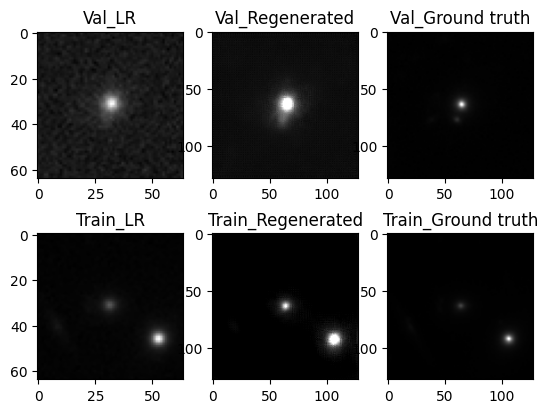

In [10]:
def show_random_image(dataset, model, length):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    i = np.random.randint(low=0,high=length)
    LR, trueHR = dataset[i]
    t1 = torch.tensor(LR.view(1,1,64,64))
    t2 = model(t1.float().to(device)).cpu().detach()
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3 = Image.fromarray(trueHR.numpy()[0]*255)
    return image1, image2, image3
pre, post, tHR = show_random_image(val_dataset, generator, 30)
pret, postt, tHRt = show_random_image(train_dataset, generator, 270)
plot, axes = plt.subplots(2,3)
axes[0][0].imshow(pre)
axes[0][1].imshow(post)
axes[0][2].imshow(tHR)
axes[0][0].set_title("Val_LR")
axes[0][1].set_title("Val_Regenerated")
axes[0][2].set_title("Val_Ground truth")

axes[1][0].imshow(pret)
axes[1][1].imshow(postt)
axes[1][2].imshow(tHRt)
axes[1][0].set_title("Train_LR")
axes[1][1].set_title("Train_Regenerated")
axes[1][2].set_title("Train_Ground truth")

In [12]:
torch.save(discriminator.state_dict(),'../trained_weights/discriminator.pt')
torch.save(generator.state_dict(),'../trained_weights/generator.pt')